<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

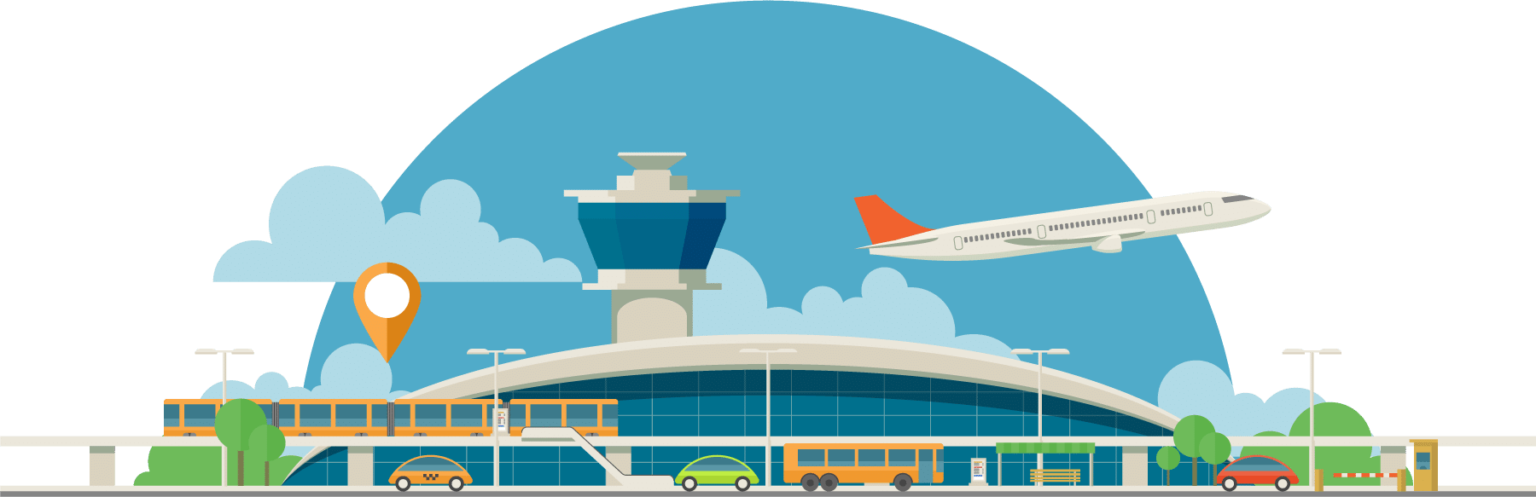

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
!pip install xgboost
!brew install cmake libomp
!pip install lightgbm

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
To reinstall 3.31.4, run:
  brew reinstall cmake
To reinstall 19.1.7, run:
  brew reinstall libomp


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-01-22 03:03:55--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Распознаётся storage.yandexcloud.net (storage.yandexcloud.net)… 2a02:6b8::1d9, 213.180.193.243
Подключение к storage.yandexcloud.net (storage.yandexcloud.net)|2a02:6b8::1d9|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3579 (3,5K) [application/x-x509-ca-cert]
Сохранение в: «/Users/yukonoff/.postgresql/root.crt»

/Users/yukonoff/.po 100%[===================>]   3,50K  --.-KB/s    за 0s      

2025-01-22 03:03:55 (3,33 GB/s) - «/Users/yukonoff/.postgresql/root.crt» сохранён [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

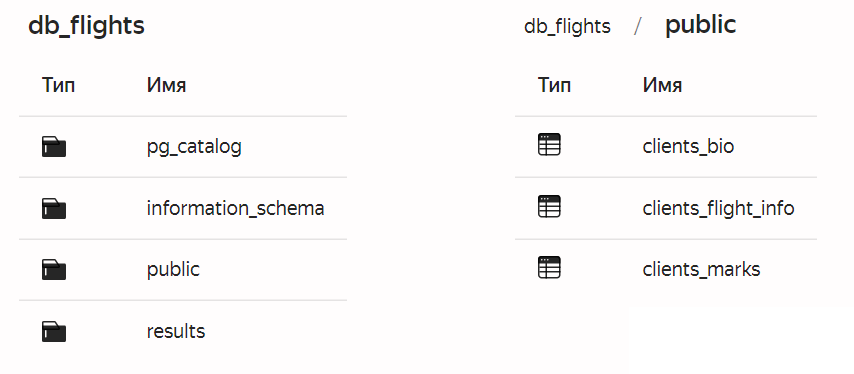



In [4]:
# Ваш код здесь
# Параметры соединения
conn_params = {
    'host': 'rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
    'port': 6432,
    'dbname': 'db_flights',
    'user': 'mlhs_student',
    'password': 'mlhs_student',
    'sslmode': 'verify-full'
}

# SQL-запрос для объединения таблиц
sql_query = """
select cfi.*, 
cb.age, cb.gender, 
cm."Inflight wifi service", cm."Departure/Arrival time convenient", cm."Ease of Online booking", cm."Gate location", cm."Food and drink", cm."Online boarding", cm."Seat comfort", cm."Inflight entertainment", cm."On-board service", cm."Leg room service", cm."Baggage handling", cm."Checkin service", cm."Inflight service", cm."cleanliness", cm."satisfaction"
from clients_flight_info cfi
inner join clients_bio cb on cb.id = cfi.id 
left outer join clients_marks cm on cfi.id = cm.id 
"""

# Подключение к базе данных и выполнение запроса
with psycopg2.connect(**conn_params) as conn:
    df = pd.read_sql_query(sql_query, conn)

# Установка индекса
df.set_index('id', inplace=True)

# Проверка загруженных данных
df.head()

/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_26360/3127544782.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,age,gender,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,43.0,Male,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,24.0,Male,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,61.0,Female,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,disloyal Customer,Business travel,Business,212.0,0.0,0.0,35.0,Male,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Loyal Customer,Business travel,Business,67.0,0.0,0.0,46.0,Female,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [5]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках).

In [6]:
# Исходный датафрейм (к вопросу о пропусках и выбросах)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Customer Type                      129549 non-null  object
 1   Type of Travel                     129549 non-null  object
 2   class                              129549 non-null  object
 3   Flight Distance                    129549 non-null  object
 4   Departure Delay in Minutes         129549 non-null  object
 5   Arrival Delay in Minutes           129549 non-null  object
 6   age                                129549 non-null  object
 7   gender                             129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [7]:
numeric_columns = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes','age',
                   'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
                   'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
                   'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling',
                   'Checkin service', 'Inflight service', 'cleanliness']
numeric_non_service = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'age']
service_columns = ['Inflight wifi service', 'Departure/Arrival time convenient',
                  'Ease of Online booking', 'Gate location', 'Food and drink',
                  'Online boarding', 'Seat comfort', 'Inflight entertainment',
                  'On-board service', 'Leg room service', 'Baggage handling',
                  'Checkin service', 'Inflight service', 'cleanliness']
categorical_columns = ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']
categorical_columns_no_target = ['gender', 'Customer Type', 'Type of Travel', 'class']

In [8]:
# просто убедиться что не напутали с именами столбцов
assert len(numeric_columns) == 18
assert len(numeric_columns) == len(numeric_non_service) + len(service_columns)
assert len(set(numeric_columns)) == len(set(numeric_non_service + service_columns))
assert len(categorical_columns) == 5
assert len(df.columns) == len(numeric_columns) + len(categorical_columns)

In [9]:
# Преобразование числовых признаков в `float`
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [10]:
# Типы данных после преобразования
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Customer Type                      129549 non-null  object 
 1   Type of Travel                     129549 non-null  object 
 2   class                              129549 non-null  object 
 3   Flight Distance                    129455 non-null  float64
 4   Departure Delay in Minutes         129442 non-null  float64
 5   Arrival Delay in Minutes           129042 non-null  float64
 6   age                                129234 non-null  float64
 7   gender                             129549 non-null  object 
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

In [11]:
# Проверка наличия пропусков. Пропуски есть, будем изучать...
df.isna().sum()

Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
age                                  315
gender                                 0
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

##### Анализ числовых признаков (кроме оценок сервиса)

In [12]:
# Описательная статистика числовых признаков (кроме оценок сервиса)
df[numeric_non_service].describe()

,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,age
count,129455.000000,129442.000000,129042.000000,129234.000000
mean,1322.922158,15.809026,16.656499,40.116951
std,4517.816532,93.276882,109.285072,20.376129
min,0.000000,0.000000,0.000000,0.000000
25%,414.000000,0.000000,0.000000,27.000000
50%,846.000000,0.000000,0.000000,40.000000
75%,1744.000000,12.000000,13.000000,51.000000
max,379620.000000,22227.000000,14006.000000,621.000000



Flight Distance:
-- L: -1581.0 -- M: 846.0 -- U: 3739.0 -- q95: 3399.0 -- q996: 3980.2
Количество выбросов за пределами усов: 3074 (2.37%)
Количество выбросов за q99.96 : 518 (0.40%)

Departure Delay in Minutes:
-- L: -18.0 -- M: 0.0 -- U: 30.0 -- q95: 78.0 -- q996: 264.0
Количество выбросов за пределами усов: 18124 (14.00%)
Количество выбросов за q99.96 : 512 (0.40%)

Arrival Delay in Minutes:
-- L: -19.5 -- M: 0.0 -- U: 32.5 -- q95: 79.0 -- q996: 265.0
Количество выбросов за пределами усов: 17499 (13.56%)
Количество выбросов за q99.96 : 512 (0.40%)

age:
-- L: -9.0 -- M: 40.0 -- U: 87.0 -- q95: 64.0 -- q996: 80.0
Количество выбросов за пределами усов: 448 (0.35%)
Количество выбросов за q99.96 : 483 (0.37%)


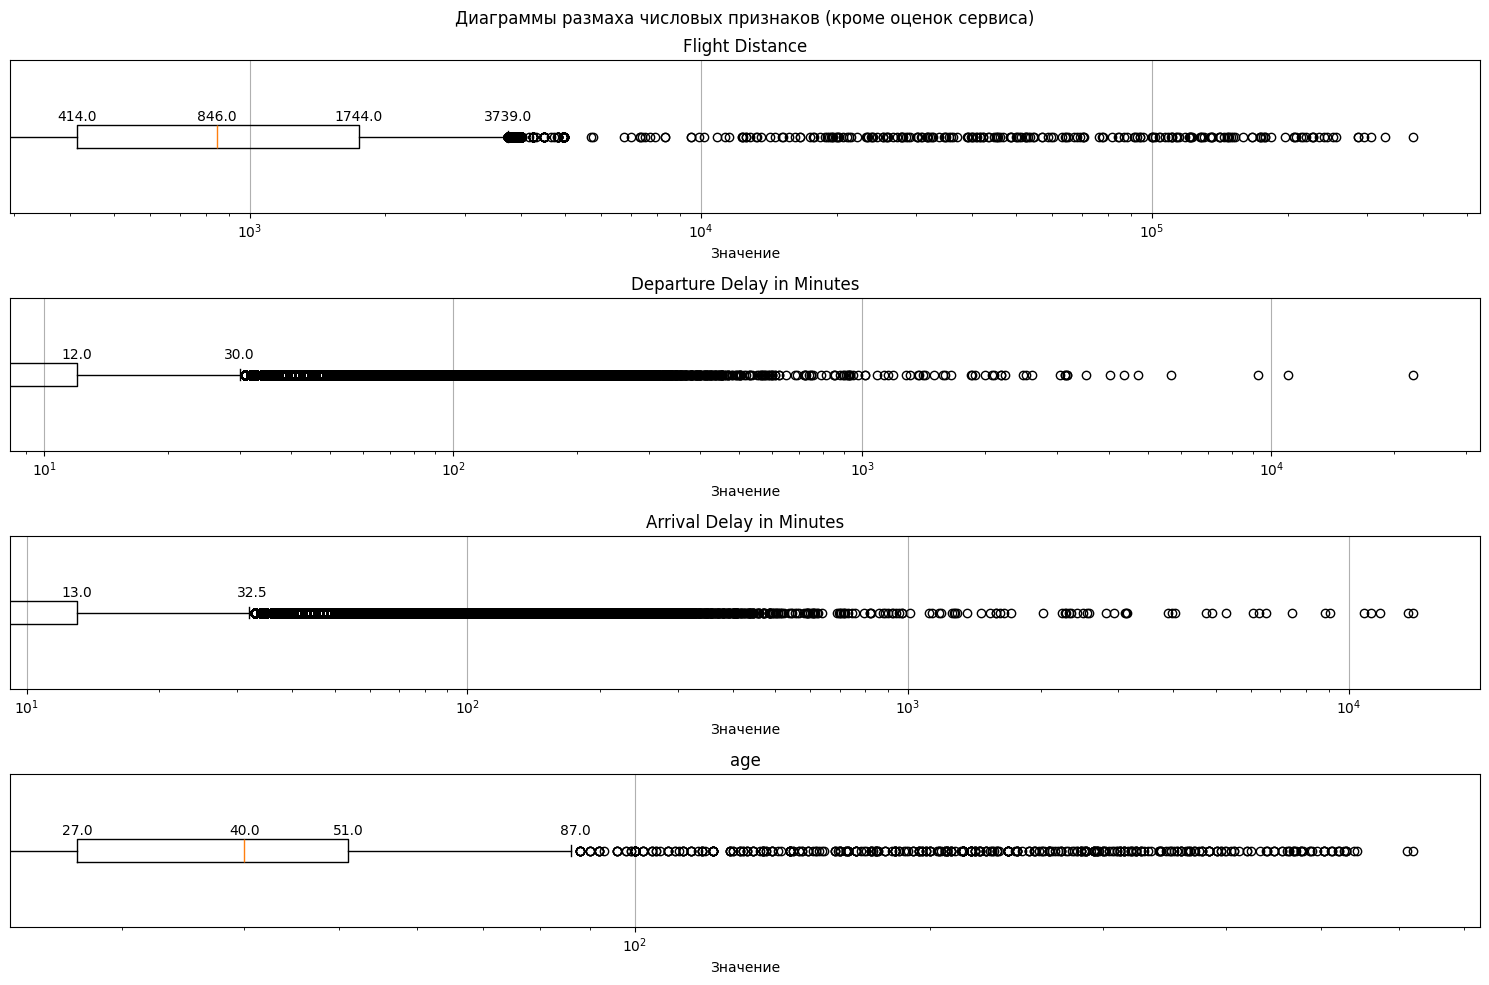

In [13]:
# Box plots для числовых признаков (кроме оценок сервиса)
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_non_service):
    # Вычисляем статистики
    data = df[col].dropna()
    median = data.median()
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    q95 = data.quantile(0.95)
    q996 = data.quantile(0.996)
    iqr = q75 - q25
    whisker_min = q25 - 1.5*iqr 
    whisker_max = q75 + 1.5*iqr
    
    outliers = data[(data < whisker_min) | (data > whisker_max)]
    outliers_q996 = data[(data > q996)]
    
    print(f"\n{col}:")
    print(f"-- L: {whisker_min:.1f} -- M: {median:.1f} -- U: {whisker_max:.1f} -- q95: {q95:.1f} -- q996: {q996:.1f}")
    print(f"Количество выбросов за пределами усов: {len(outliers)} ({(len(outliers) / len(data) * 100):.2f}%)")
    print(f"Количество выбросов за q99.96 : {len(outliers_q996)} ({(len(outliers_q996) / len(data) * 100):.2f}%)")

    # Строим boxplot
    axes[i].boxplot(data, vert=False)
    axes[i].set_title(col)
    axes[i].set_xlabel('Значение')
    axes[i].set_yticks([])
    axes[i].grid(True)
    axes[i].set_xscale('log')  # Устанавливаем логарифмический масштаб для оси x
 
    # Подписываем границы box plot
    if whisker_min > 0: 
        axes[i].text(whisker_min, 1.1, f'{whisker_min:.1f}', ha='center')  # Нижний ус
    if q25 > 0:
        axes[i].text(q25, 1.1, f'{q25:.1f}', ha='center')  # Нижняя граница ящика
    if median > 0:
        axes[i].text(median, 1.1, f'{median:.1f}', ha='center')  # Медиана
    if q75 > 0:
        axes[i].text(q75, 1.1, f'{q75:.1f}', ha='center')  # Верхняя граница ящика  
    if whisker_max > 0:
        axes[i].text(whisker_max, 1.1, f'{whisker_max:.1f}', ha='center')  # Верхний ус
    # if q95 > 0:
    #     axes[i].text(q95, 0.85, f'q95: {q95:.1f}', ha='center')  # Верхний 95%
    # if q99 > 0:
    #     axes[i].text(q99, 0.85, f'q99: {q99:.1f}', ha='center')  # Верхний 99%
    
fig.suptitle("Диаграммы размаха числовых признаков (кроме оценок сервиса)")
plt.tight_layout()
plt.show()


##### Предварительные выводы по числовым признакам (кроме оценок сервиса):

| Характеристика | Flight Distance | Departure Delay | Arrival Delay | Age |
|----------------|-----------------|-----------------|---------------|-----|
| Разброс значений | 0-379620 км | 0-22227 минут | 0-14006 минут | 0-621 лет |
| Медиана | 846 км | 0 минут | 0 минут | 40 лет |
| q75% | 1744 км | 12 минут | 13 минут | 51 год |
| M+1.5*IQR (верхний "ус") | 3739 км | 30 минут | 32.5 минут | 87 лет |
| Выбросы за M+1.5*IQR (шт.) | 3074 (2.37%) | 18124 (14.00%) | 17499 (13.56%) | 448 (0.35%) |
| q95% | 3399 км | 78 минут | 79 минут | 64 года |
| q99.96% | 3980.2 км | 264 минут | 265 минут | 80 лет |
| Выбросы за q99.96 (шт.) | 518 (0.40%) | 512 (0.40%) | 512 (0.40%) | 483 (0.37%) |
| Пропущенные значения | 94 (0.07%) | 107 (0.08%) | 507 (0.39%) | 315 (0.24%) |


##### Анализ категориальных признаков

In [14]:
# Проверка категориальных признаков
for column in categorical_columns:
    print("=====", column, "=====")
    print(df[column].value_counts())

===== gender =====
gender
Female    65726
Male      63823
Name: count, dtype: int64
===== Customer Type =====
Customer Type
Loyal Customer       105763
disloyal Customer     23709
nan                      77
Name: count, dtype: int64
===== Type of Travel =====
Type of Travel
Business travel    89405
Personal Travel    40043
nan                  101
Name: count, dtype: int64
===== class =====
class
Business    61939
Eco         58115
Eco Plus     9379
nan           116
Name: count, dtype: int64
===== satisfaction =====
satisfaction
neutral or dissatisfied    58732
satisfied                  44912
-                          25905
Name: count, dtype: int64


In [15]:
# Подсчет строк с nan в категориальных признаках
for column in categorical_columns:
    nan_count = df[df[column] == 'nan'][column].count()
    nan_percent = (nan_count / len(df)) * 100
    print(f"Количество строк со значением 'nan' в {column}: {nan_count} ({nan_percent:.2f}%)")


Количество строк со значением 'nan' в gender: 0 (0.00%)
Количество строк со значением 'nan' в Customer Type: 77 (0.06%)
Количество строк со значением 'nan' в Type of Travel: 101 (0.08%)
Количество строк со значением 'nan' в class: 116 (0.09%)
Количество строк со значением 'nan' в satisfaction: 0 (0.00%)


Видно, что
- значение `nan` встречается в признаках `Customer Type`, `Type of Travel` и `class` реже чем 0.1% - это пропуски, которые **можно удалить или заполнить самым частым значением**
- значение `-` встречается в признаке `satisfaction` в 25905 строк, что составляет ~20% от всех строк.

In [16]:
# Заменяем строковые 'nan' на np.nan в категориальных столбцах
for column in categorical_columns:
    df[column] = df[column].replace('nan', np.nan)


##### Анализ "признаков оценки сервиса"

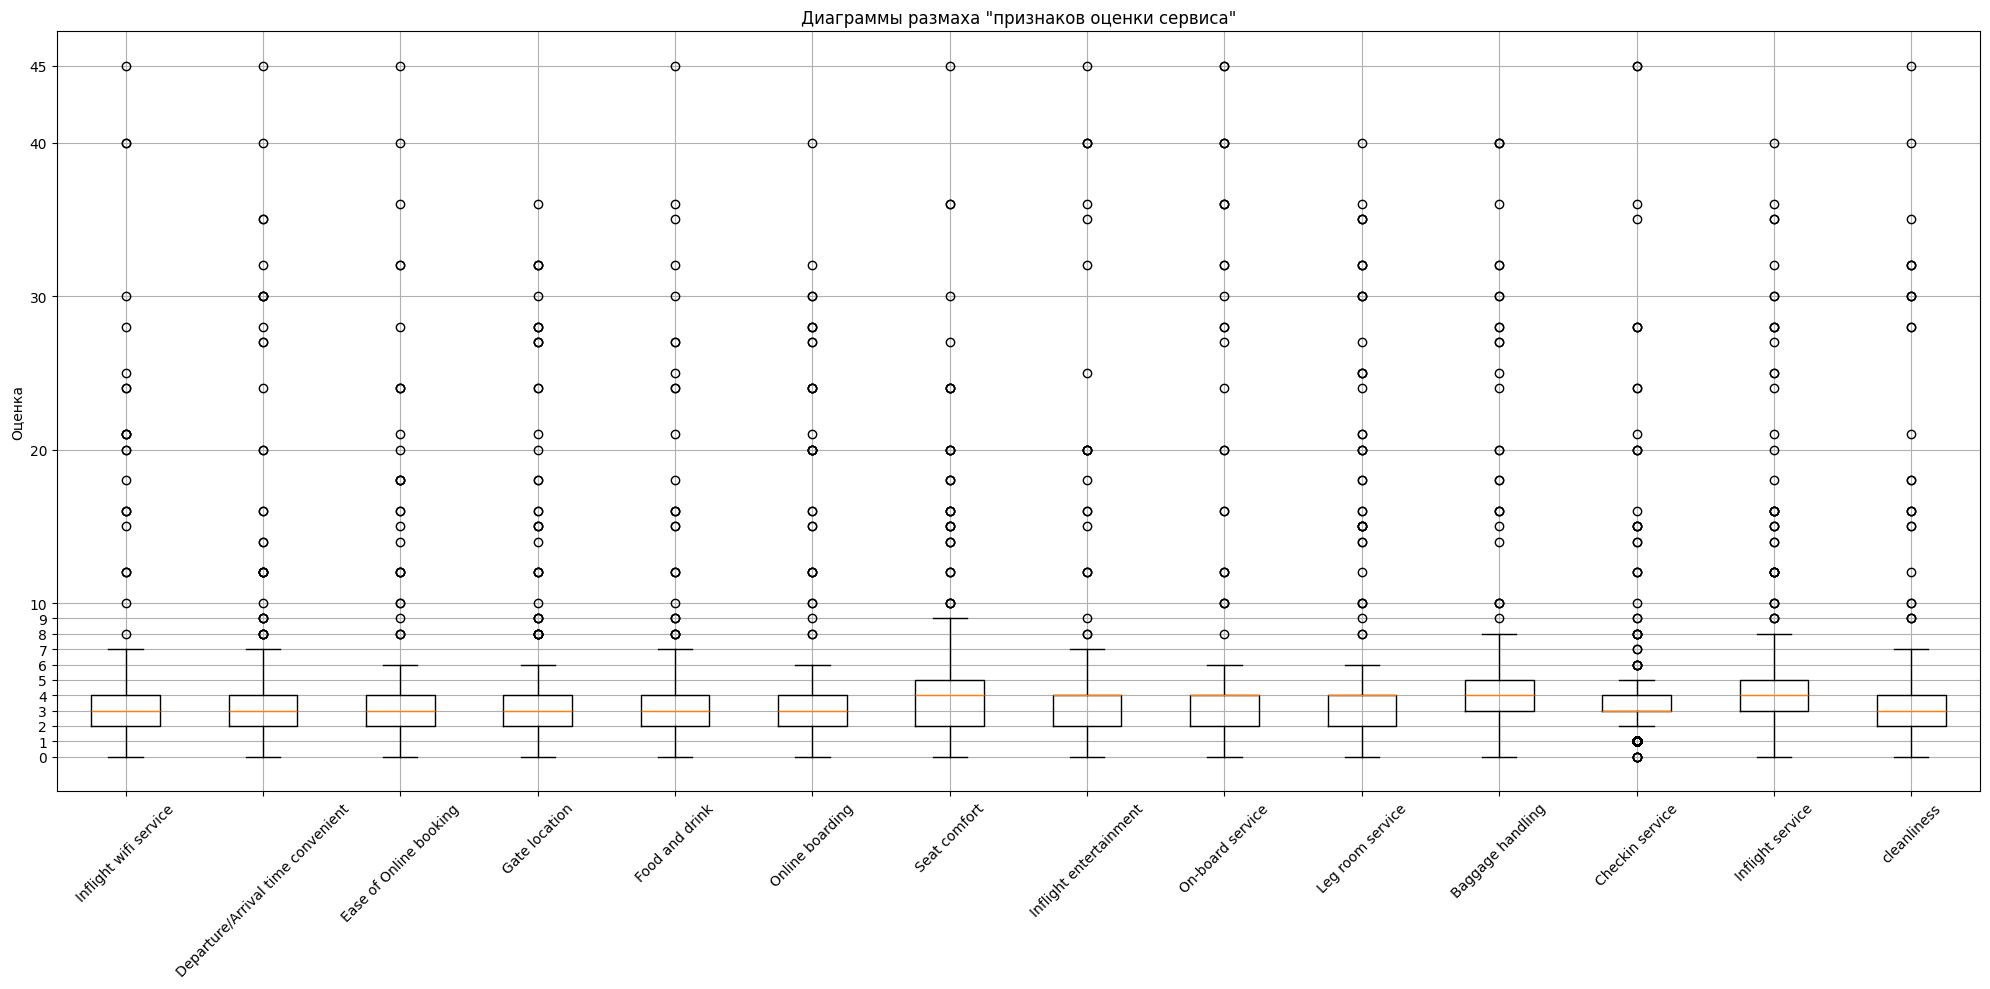

In [17]:
# Построение box plots для "признаков оценки сервиса"
plt.figure(figsize=(20,10))
plt.boxplot([df[col].dropna() for col in service_columns], tick_labels=service_columns)
plt.xticks(rotation=45)
plt.title('Диаграммы размаха "признаков оценки сервиса"')
plt.ylabel('Оценка')
plt.grid(True)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 45])
plt.tight_layout()
plt.show()


#### Выводы о пропусках и выбросах в данных

В изначальном датафрейме пропусков нет (все значения формально заполнены).  
Однако, не все преобразования числовых признаков в `float` прошли успешно, появились пропуски.

##### Пропуски и выбросы в числовых признаках:
| Характеристика | Flight Distance | Departure Delay | Arrival Delay | Age |
|----------------|-----------------|-----------------|---------------|-----|
| Разброс значений | 0-379620 км | 0-22227 минут | 0-14006 минут | 0-621 лет |
| Медиана | 846 км | 0 минут | 0 минут | 40 лет |
| q75% | 1744 км | 12 минут | 13 минут | 51 год |
| M+1.5*IQR (верхний "ус") | 3739 км | 30 минут | 32.5 минут | 87 лет |
| Выбросы за M+1.5*IQR (шт.) | 3074 (2.37%) | 18124 (14.00%) | 17499 (13.56%) | 448 (0.35%) |
| q95% | 3399 км | 78 минут | 79 минут | 64 года |
| q99.96% | 3980.2 км | 264 минут | 265 минут | 80 лет |
| Выбросы за q99.96 (шт.) | 518 (0.40%) | 512 (0.40%) | 512 (0.40%) | 483 (0.37%) |
| Пропущенные значения | 94 (0.07%) | 107 (0.08%) | 507 (0.39%) | 315 (0.24%) |

В `признаках оценки сервиса` (14 числовых признаков): 37-63 пропуска в каждом

В категориальных признаках есть строковые значения `nan`, т.е. по-сути - пропуски:
  - `Customer Type`: 77
  - `Type of Travel`: 101
  - `class`: 116

Количество пропусков незначительно, поэтому их **все можно удалить или заполнить самым частым значением**.

##### НЕ-пропуски
В `gender` пропусков нет.  

В `satisfaction` начение `-` (25905 шт., ~20% данных) - это технически пропуски, но их мы будем предсказывать при обучении модели.

##### Выбросы
В категориальных признаках выбросов нет - все значения валидны.

В числовых признаках есть явные выбросы, так:
 - В `признаках оценки сервиса` подавляющее большинство значений из диапазона `1-5`, при этом
   - максимальные значения достигают `45` - это выбросы, (есть вероятность, что это ошибки ввода или оценки типа "4 или 5")
   - значение `0` встречается значительно реже `1-5`, что тоже может быть ошибкой ввода.
- `Flight Distance`:
  - Большой разброс (0-379620 км)
  - Выбросы за M+1.5*IQR (3739 км): 3074 (2.37%) - **много, чтобы просто удалить...**
  - Выбросы за q99.96 (3980 км): 512 (0.40%) - **а это можно удалить**

- `Departure Delay`:
  - Большой разброс значений (0-22227 минут)
  - Медиана - 0 минут (50% рейсов нет задержек)
  - Выбросы за M+1.5*IQR (30 минут): 18124 (14.00%) - **нельзя удалять т.к. даже 10000 минут - это 166 часов, примерно 7 дней, что в принципе возможно**
  - ыбросы за q99.96 (264 мин): 518 (0.40%) - **можно удалить**

- `Arrival Delay`:  
  - Большой разброс значений (0-14006 минут)
  - Медиана - 0 минут (50% рейсов нет задержек)
  - Выбросы за M+1.5*IQR (32.5 мин): 17499 (13.56%) - **нужно оставить - все возможно см. выше**
  - Выбросы за q99.96 (265 мин): 512 (0.40%) - **можно удалить**
 
 - `Age`:
   - Большой разброс (0-621 лет)
   - Медиана - 40 лет
   - Выбросы за M+1.5*IQR (87 лет): 448 (0.35%) - **можно удалить**
   - Выбросы за q99.96 (80 лет): 483 (0.37%) - **можно удалить**


### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Figure size 1500x800 with 0 Axes>

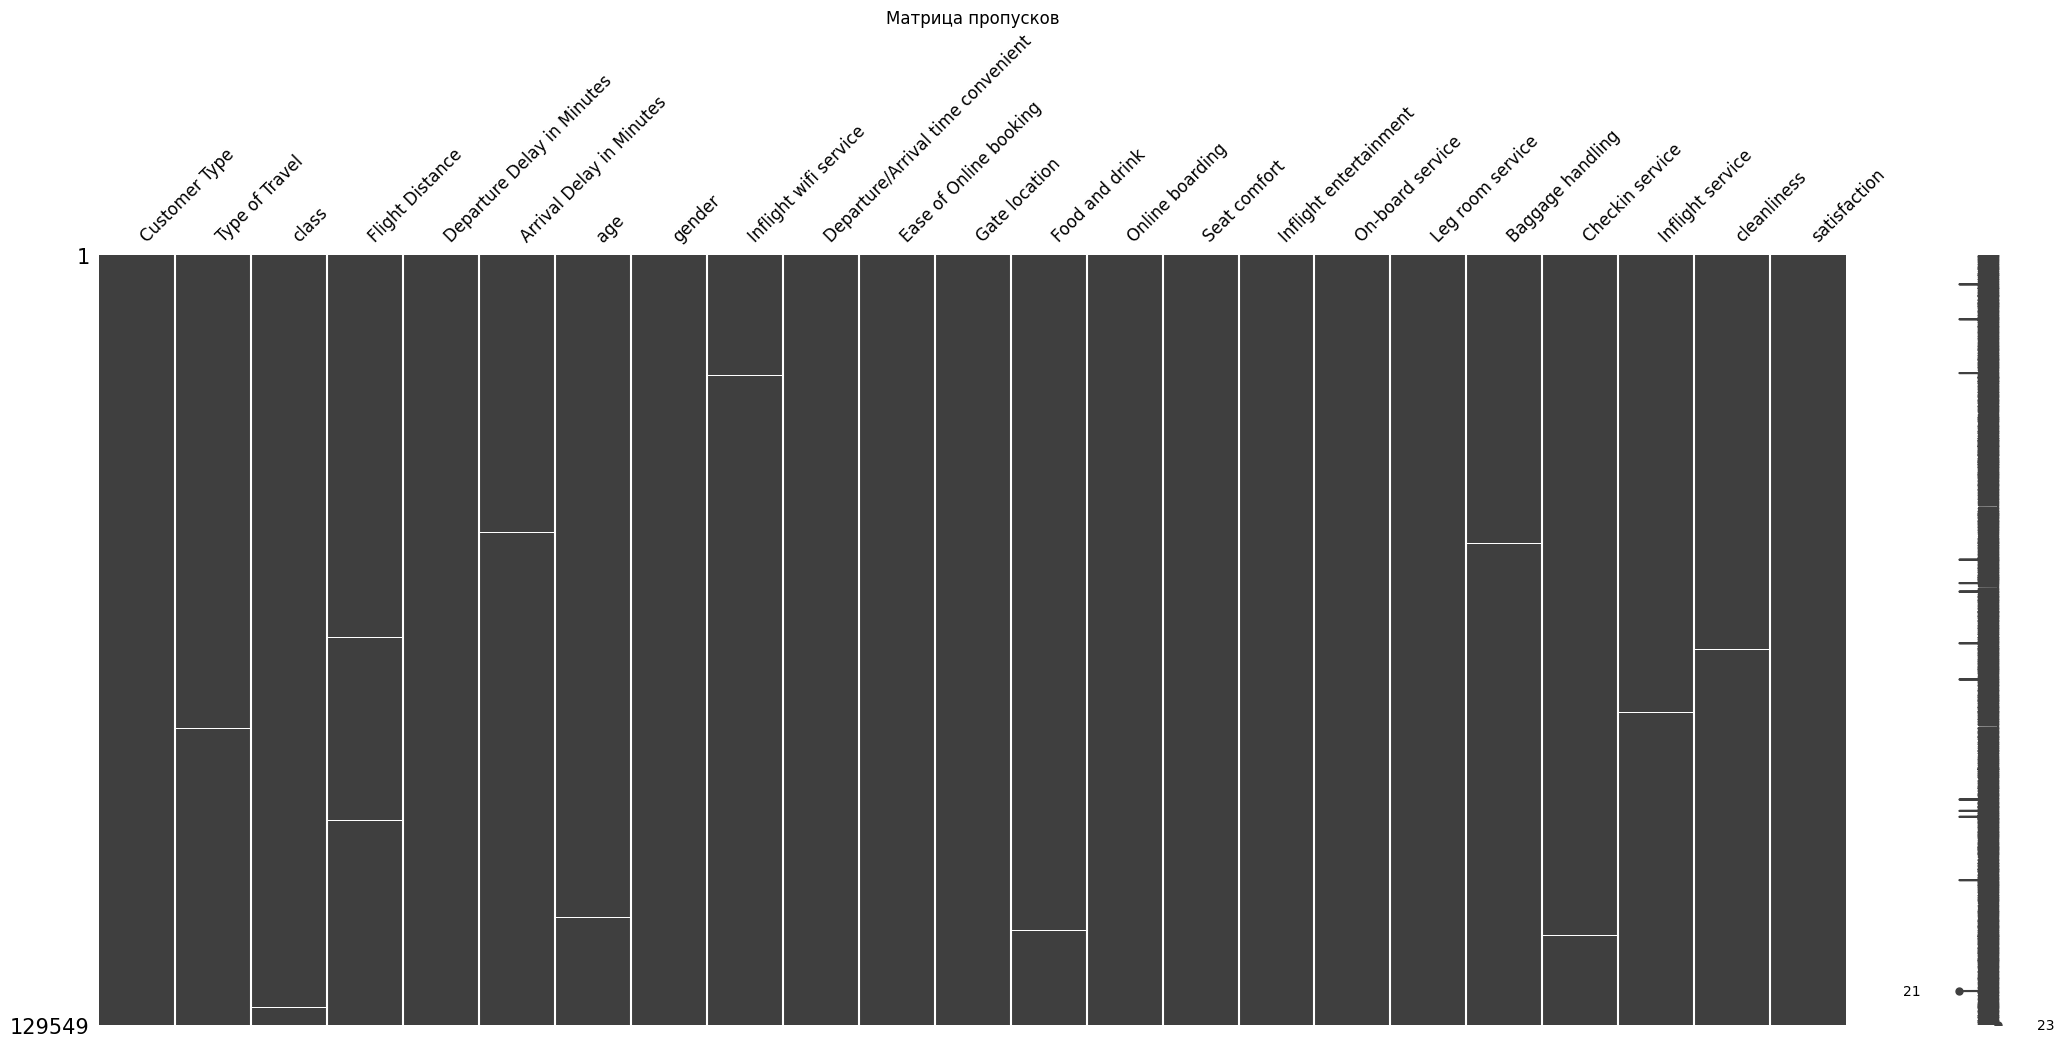

In [18]:
# Ваш код ниже
plt.figure(figsize=(15,8))
msno.matrix(df, fontsize=12)
plt.title('Матрица пропусков')
plt.show()

/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


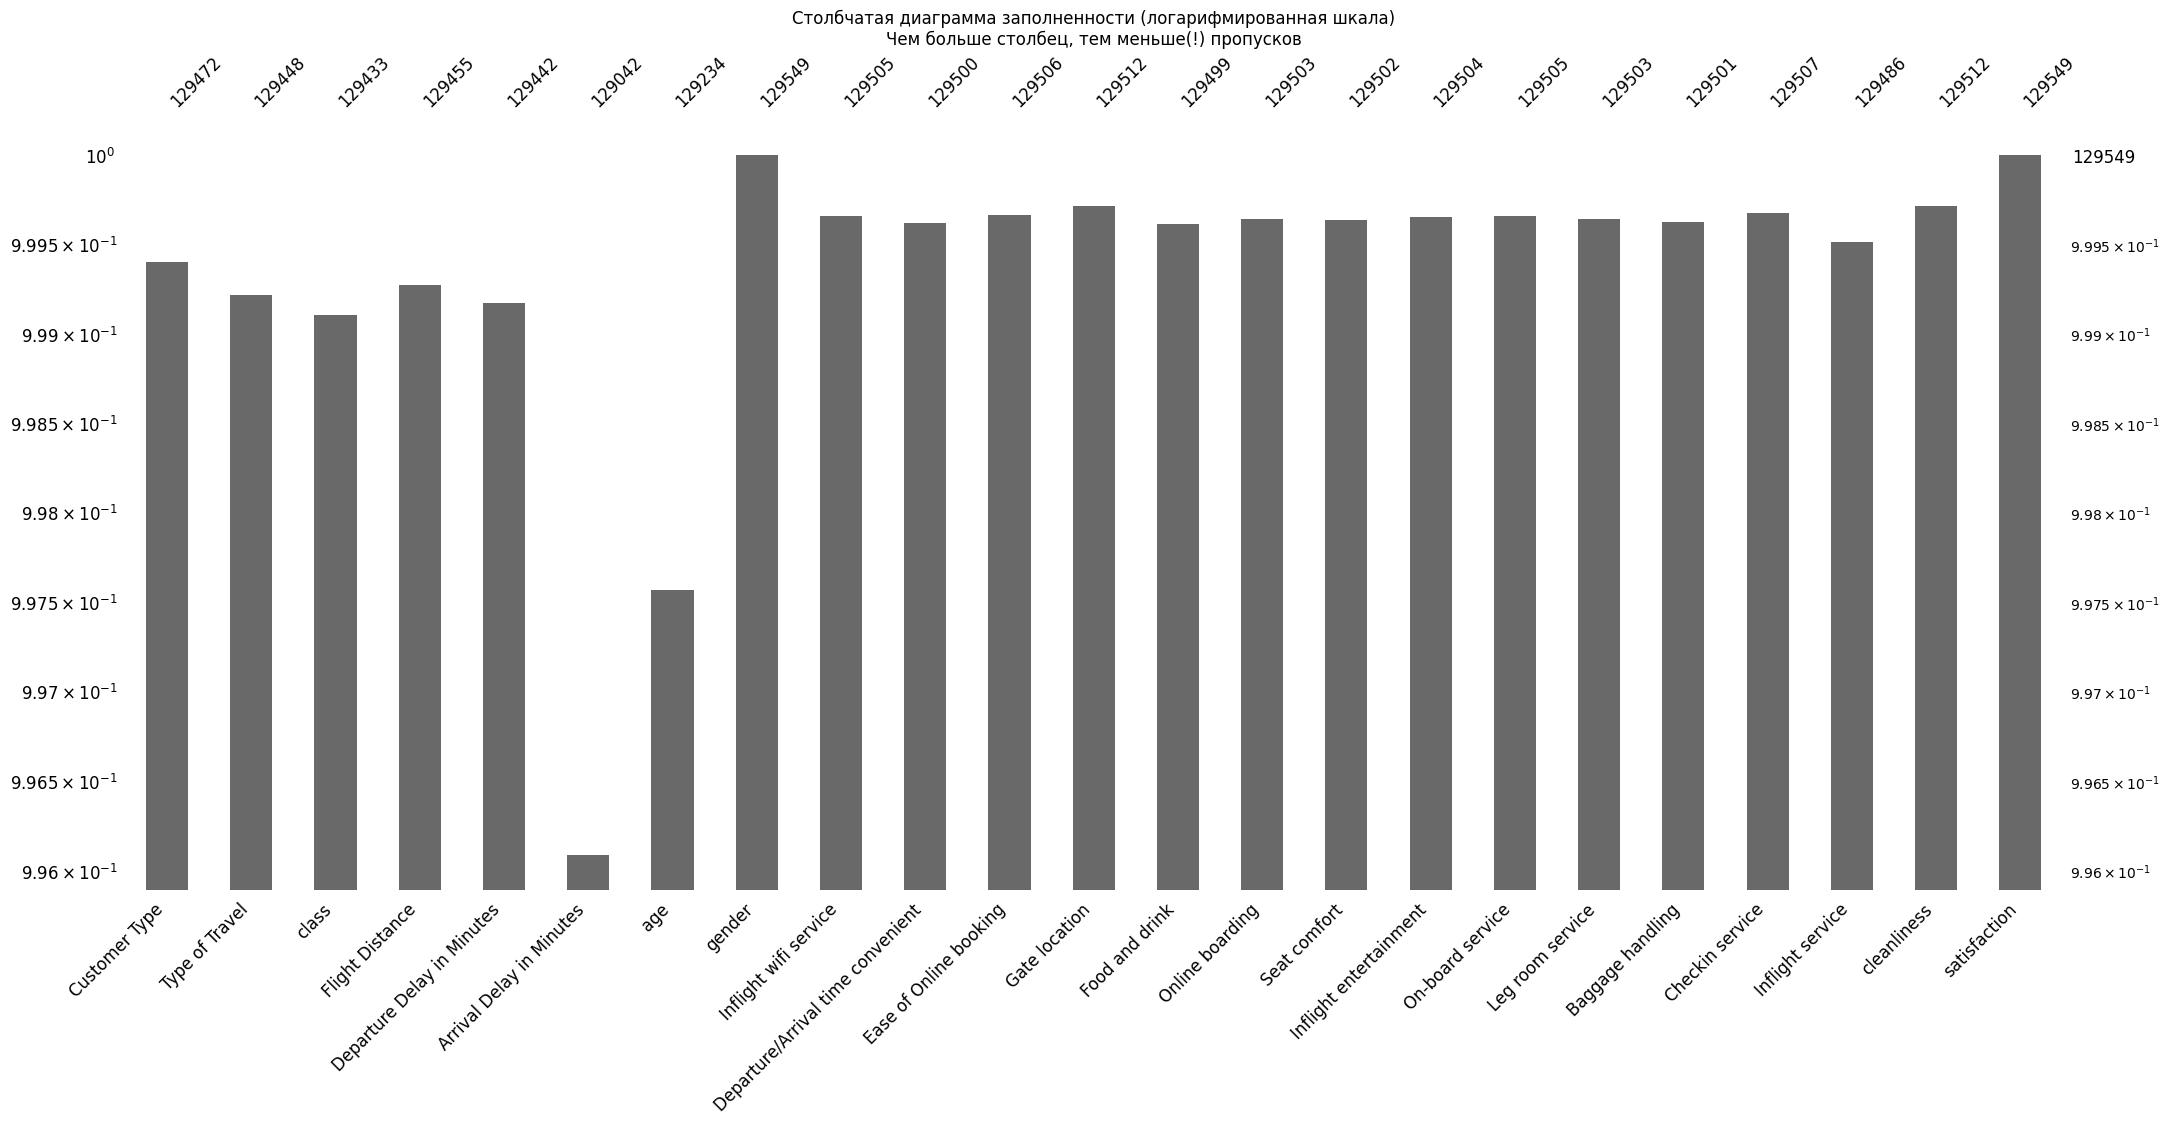

In [19]:
# Ваш код ниже
plt.figure(figsize=(15,8)) 
msno.bar(df, log=True, fontsize=12)
plt.title('Столбчатая диаграмма заполненности (логарифмированная шкала)\nЧем больше столбец, тем меньше(!) пропусков')
plt.show()


Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [20]:
df_train = df[df.satisfaction != '-']
df_train

,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,age,gender,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,43.0,Male,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,24.0,Male,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,61.0,Female,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,disloyal Customer,Business travel,Business,212.0,0.0,0.0,35.0,Male,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Loyal Customer,Business travel,Business,67.0,0.0,0.0,46.0,Female,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129831,Loyal Customer,Personal Travel,Eco,447.0,23.0,16.0,28.0,Female,1.0,3.0,...,1.0,3.0,3.0,1.0,1.0,4.0,1.0,5.0,3.0,neutral or dissatisfied
129837,Loyal Customer,Personal Travel,Eco,337.0,199.0,213.0,66.0,Male,2.0,4.0,...,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,5.0,neutral or dissatisfied
129838,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,59.0,Female,3.0,5.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,neutral or dissatisfied


In [21]:
assert df_train.shape == (103_644, 23)

In [22]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,age,gender,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,36.0,Male,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,70.0,Female,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,66.0,Male,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,60.0,Female,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,43.0,Male,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,Loyal Customer,Business travel,Eco,337.0,92.0,82.0,38.0,Male,4.0,3.0,...,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0
129771,Loyal Customer,Personal Travel,Eco,308.0,2.0,0.0,16.0,Male,3.0,4.0,...,1.0,3.0,5.0,1.0,4.0,2.0,5.0,5.0,4.0,1.0
129798,Loyal Customer,Personal Travel,Eco,308.0,0.0,0.0,43.0,Female,2.0,4.0,...,3.0,5.0,5.0,4.0,4.0,2.0,4.0,4.0,4.0,5.0


In [23]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [24]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [25]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [26]:
# Ваш код ниже
imputer = SimpleImputer(strategy='most_frequent').set_output(transform="pandas")

# На трейне обучим и применим
X_train_imputed = imputer.fit_transform(X_train)
X_train_imputed[numeric_columns] = X_train_imputed[numeric_columns].apply(pd.to_numeric, errors='coerce')

# На валидации только применим
X_val_imputed = imputer.transform(X_val)
X_val_imputed[numeric_columns] = X_val_imputed[numeric_columns].apply(pd.to_numeric, errors='coerce')

# На тесте только применим
df_test_imputed = imputer.transform(df_test)
df_test_imputed[numeric_columns] = df_test_imputed[numeric_columns].apply(pd.to_numeric, errors='coerce')


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [27]:
# Ваш код ниже
X_train_imputed[numeric_columns].describe()

,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,age,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000
mean,1329.018332,15.859366,16.645968,40.098856,2.733687,3.065017,2.761006,2.982688,3.209318,3.256513,3.445665,3.362150,3.383101,3.352364,3.630255,3.309056,3.640234,3.291178
std,4764.369357,70.861937,97.990293,20.658196,1.362172,1.552254,1.414843,1.316648,1.349963,1.372739,1.346077,1.360862,1.333758,1.360180,1.227853,1.293114,1.215114,1.343302
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,413.000000,0.000000,0.000000,27.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,844.000000,0.000000,0.000000,40.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,1744.000000,12.000000,13.000000,51.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,379620.000000,9282.000000,11760.000000,544.000000,45.000000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


In [28]:
X_train_imputed[categorical_columns_no_target].describe()

,gender,Customer Type,Type of Travel,class
count,72550,72550,72550,72550
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,36816,59406,50054,34793


In [29]:
for col in categorical_columns_no_target:
    print(f"\nБаланс классов для {col}:")
    print(X_train_imputed[col].value_counts(normalize=True).mul(100).round(2))
    print("-" * 50)


Баланс классов для gender:
gender
Female    50.75
Male      49.25
Name: proportion, dtype: float64
--------------------------------------------------

Баланс классов для Customer Type:
Customer Type
Loyal Customer       81.88
disloyal Customer    18.12
Name: proportion, dtype: float64
--------------------------------------------------

Баланс классов для Type of Travel:
Type of Travel
Business travel    68.99
Personal Travel    31.01
Name: proportion, dtype: float64
--------------------------------------------------

Баланс классов для class:
class
Business    47.96
Eco         44.86
Eco Plus     7.18
Name: proportion, dtype: float64
--------------------------------------------------


In [30]:
# Баланс классов для целевого признака `satisfaction`
y_train.value_counts(normalize=True).mul(100).round(2)


satisfaction
neutral or dissatisfied    56.63
satisfied                  43.37
Name: proportion, dtype: float64

#### Выводы о распределениях значений признаков

На основе предоставленных данных и описательной статистики, можно сделать следующие выводы о распределениях значений признаков:

**Числовые признаки:**
- `Flight Distance`: Имеет большой разброс значений, с медианой 844 км. Большинство полетов (75%) короче 1744 км, но есть значительное количество выбросов, особенно выше 15349 км, что превышает длину самого длинного коммерческого рейса.

- `Departure Delay in Minutes`: Большинство рейсов не имеют задержек (медиана 0 минут), но есть значительное количество выбросов, особенно выше 30 минут. 75% задержек не превышают 12 минут. Хотя 99.96% задержек не превышают 264 минуты, но даже значения в 10000 минут теоретически допустимы (это 166 часов или примерно 7 дней, что в принципе возможно).

- `Arrival Delay in Minutes`: Похожая ситуация с задержками на прибытие, где медиана также 0 минут, и 75% задержек не превышают 13 минут и выбросы до 11760 минут (196 часов или примерно 8 дней).

- `Age`: Возраст пассажиров варьируется от 0 до 544 лет, что явно указывает на ошибки в данных. Медиана составляет 40 лет, и 75% пассажиров младше 51 года.

**Признаки оценки сервиса:**
В `признаках оценки сервиса` подавляющее большинство значений из диапазона `1-5`, при этом
 - максимальные значения достигают `45` - это выбросы, (возможно, что это ошибки ввода или оценки типа "4 или 5")
 - значение `0` встречается значительно реже `1-5`, что тоже может быть ошибкой ввода.

**Категориальные признаки:**
- `gender`, `Customer Type`, `Type of Travel`, `class`: Эти признаки не имеют пропусков и имеют 2-3 уникальных значения, что характерно для категориальных данных.
  
- Распределение классов
  - `gender`: соотношение женщин и мужчин 51:49 - сбалансированно
  - `Customer Type`: соотношение "Loyal Customer" и "disloyal Customer" 82:18 - **несбалансированно**
  - `Type of Travel`: соотношение "Personal Travel" и "Business travel" 31:69 - **несбалансированно**
  - `class`: соотношение "Business", "Eco" и "Eco Plus" 48:45:7 - **несбалансированно**

**Целевой признак**
- `satisfaction`: соотношение "satisfied" и "neutral or dissatisfied" 43:57 - не идеально, но не критично

**Пропуски и выбросы:**
Пропуски были заполнены наиболее часто встречающимся значением.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [31]:
# Ваш код ниже

# вектор значений квантиля 0.996 для числовых признаков
quantiles = X_train_imputed[numeric_columns].quantile(0.996)

# маска для строк, которые нужно оставить (где все значения меньше или равны их 0.996 квантилю)
mask_train = (X_train_imputed[numeric_columns] <= quantiles).all(axis=1)
mask_val = (X_val_imputed[numeric_columns] <= quantiles).all(axis=1)

# отфильтруем трейн и валидацию
X_train_filtered = X_train_imputed[mask_train]
X_val_filtered = X_val_imputed[mask_val]

print("Размерность трейна после удаления выбросов:", X_train_filtered.shape)
print("Размерность валидации после удаления выбросов:", X_val_filtered.shape)
print("Размерность теста (не изменялась):", df_test_imputed.shape)


Размерность трейна после удаления выбросов: (71395, 22)
Размерность валидации после удаления выбросов: (30600, 22)
Размерность теста (не изменялась): (25905, 22)


In [32]:
X_train = X_train_filtered
X_val = X_val_filtered
df_test = df_test_imputed

In [33]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [34]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [35]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [36]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    n_cols = len(cols)
    n_rows = (n_cols + 1) // 4  # Ceiling division to handle odd number of columns
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))
    fig.suptitle('Распределения порядковых признаков по "satisfaction"', fontsize=18)
    
    # Handle single column case
    if n_cols == 1:
        axes = np.array([[axes]])
    # Flatten axes for easier iteration    
    axes = axes.flatten()
    
    for i, (ax, col) in enumerate(zip(axes, cols)):
        sns.countplot(data=df, x=col, hue=y, ax=ax)
        ax.set_title(f'"{col}"', fontsize=16)
        ax.set_xlabel(f'Оценка за "{col}"')
        ax.set_ylabel('Количество')
        ax.tick_params(axis='x')
        ax.legend(loc='upper left')
    
    # Hide empty subplots if odd number of columns
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()


In [37]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    n_cols = len(cols)
    # Чтобы разместить заголовки, сделаем "сетку" из 4 строк и n_cols столбцов.
    # gridspec для того, чтобы заголовки "наложились" на соседние оси, а не "раздвигали" их
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(4, n_cols, height_ratios=[0.2, 2, 0.2, 1])
    
    # Оси для заголовков
    title_ax1 = fig.add_subplot(gs[0, :])
    title_ax1.text(0.5, 0.5, 'Распределения непрерывных признаков', 
                  horizontalalignment='center', fontsize=18)
    title_ax1.axis('off')
    
    title_ax2 = fig.add_subplot(gs[2, :])
    title_ax2.text(0.5, 0.5, 'Диаграммы размаха',
                  horizontalalignment='center', fontsize=18)
    title_ax2.axis('off')
    
    # Оси для основных графиков
    axes = [[fig.add_subplot(gs[1, i]) for i in range(n_cols)],
            [fig.add_subplot(gs[3, i]) for i in range(n_cols)]]
    
    for i, col in enumerate(cols):
        # KDE plot
        sns.kdeplot(data=df, x=col, hue=y, ax=axes[0][i])
        axes[0][i].set_title(f'"{col}" по "satisfaction"')
        axes[0][i].set_xlabel(col)
        axes[0][i].set_ylabel('Плотность')
        
        # Box plot
        sns.boxplot(data=df, x=y, y=col, ax=axes[1][i], hue=y)
        axes[1][i].set_title(f'"{col}" по "satisfaction"')
        axes[1][i].set_xlabel('satisfaction')
        axes[1][i].set_ylabel(col)
        
    plt.tight_layout()
    plt.show()

In [38]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    n_cols = len(cols)
    n_rows = (n_cols + 1) // 4  # Calculate the number of rows needed
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    fig.suptitle('Распределения категориальных признаков по "satisfaction"', fontsize=18)

    for ax, col in zip(axes, cols):
        sns.countplot(data=df, x=col, hue=y, ax=ax)
        ax.set_title(f'"{col}"', fontsize=16)
        ax.set_xlabel(col)
        ax.set_ylabel('Количество')
        ax.tick_params(axis='x')

    # Hide any unused axes
    for ax in axes[n_cols:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

Отрисовка.

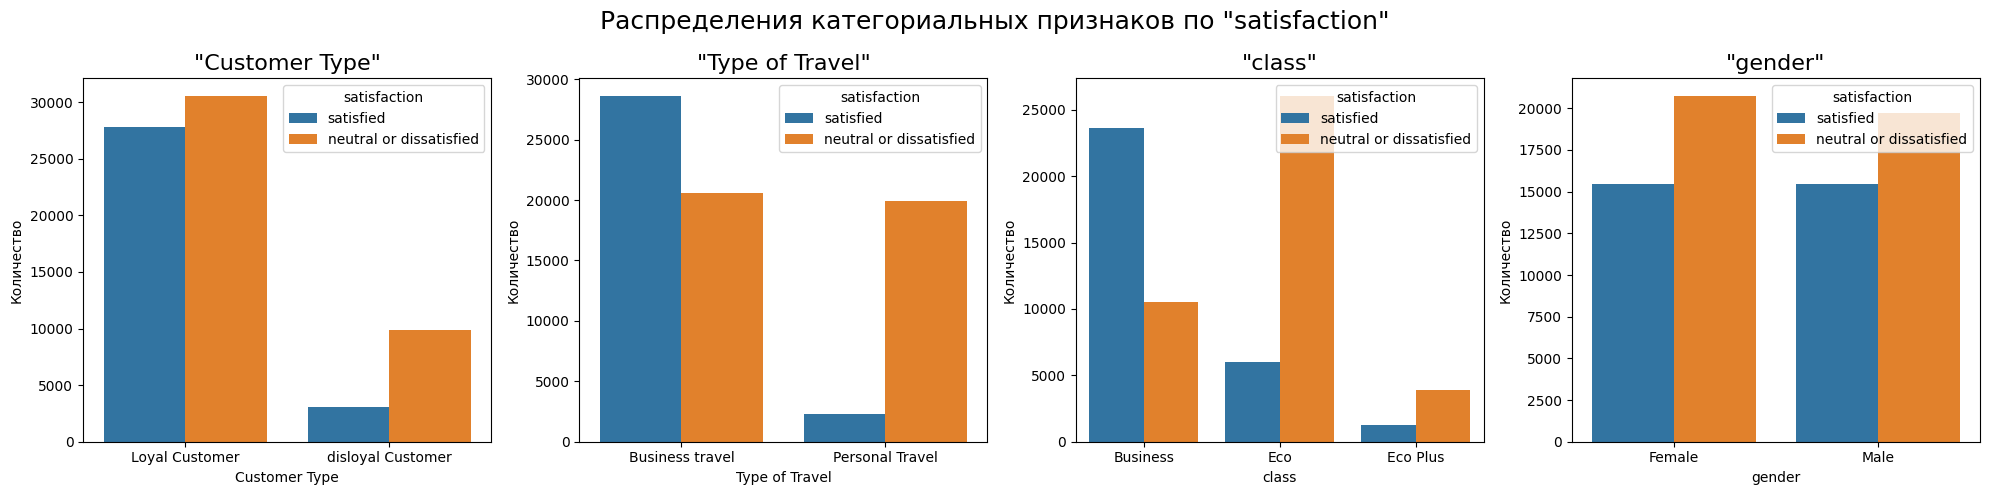

In [39]:
plot_categorical(categorical_cols, X_train, y_train)

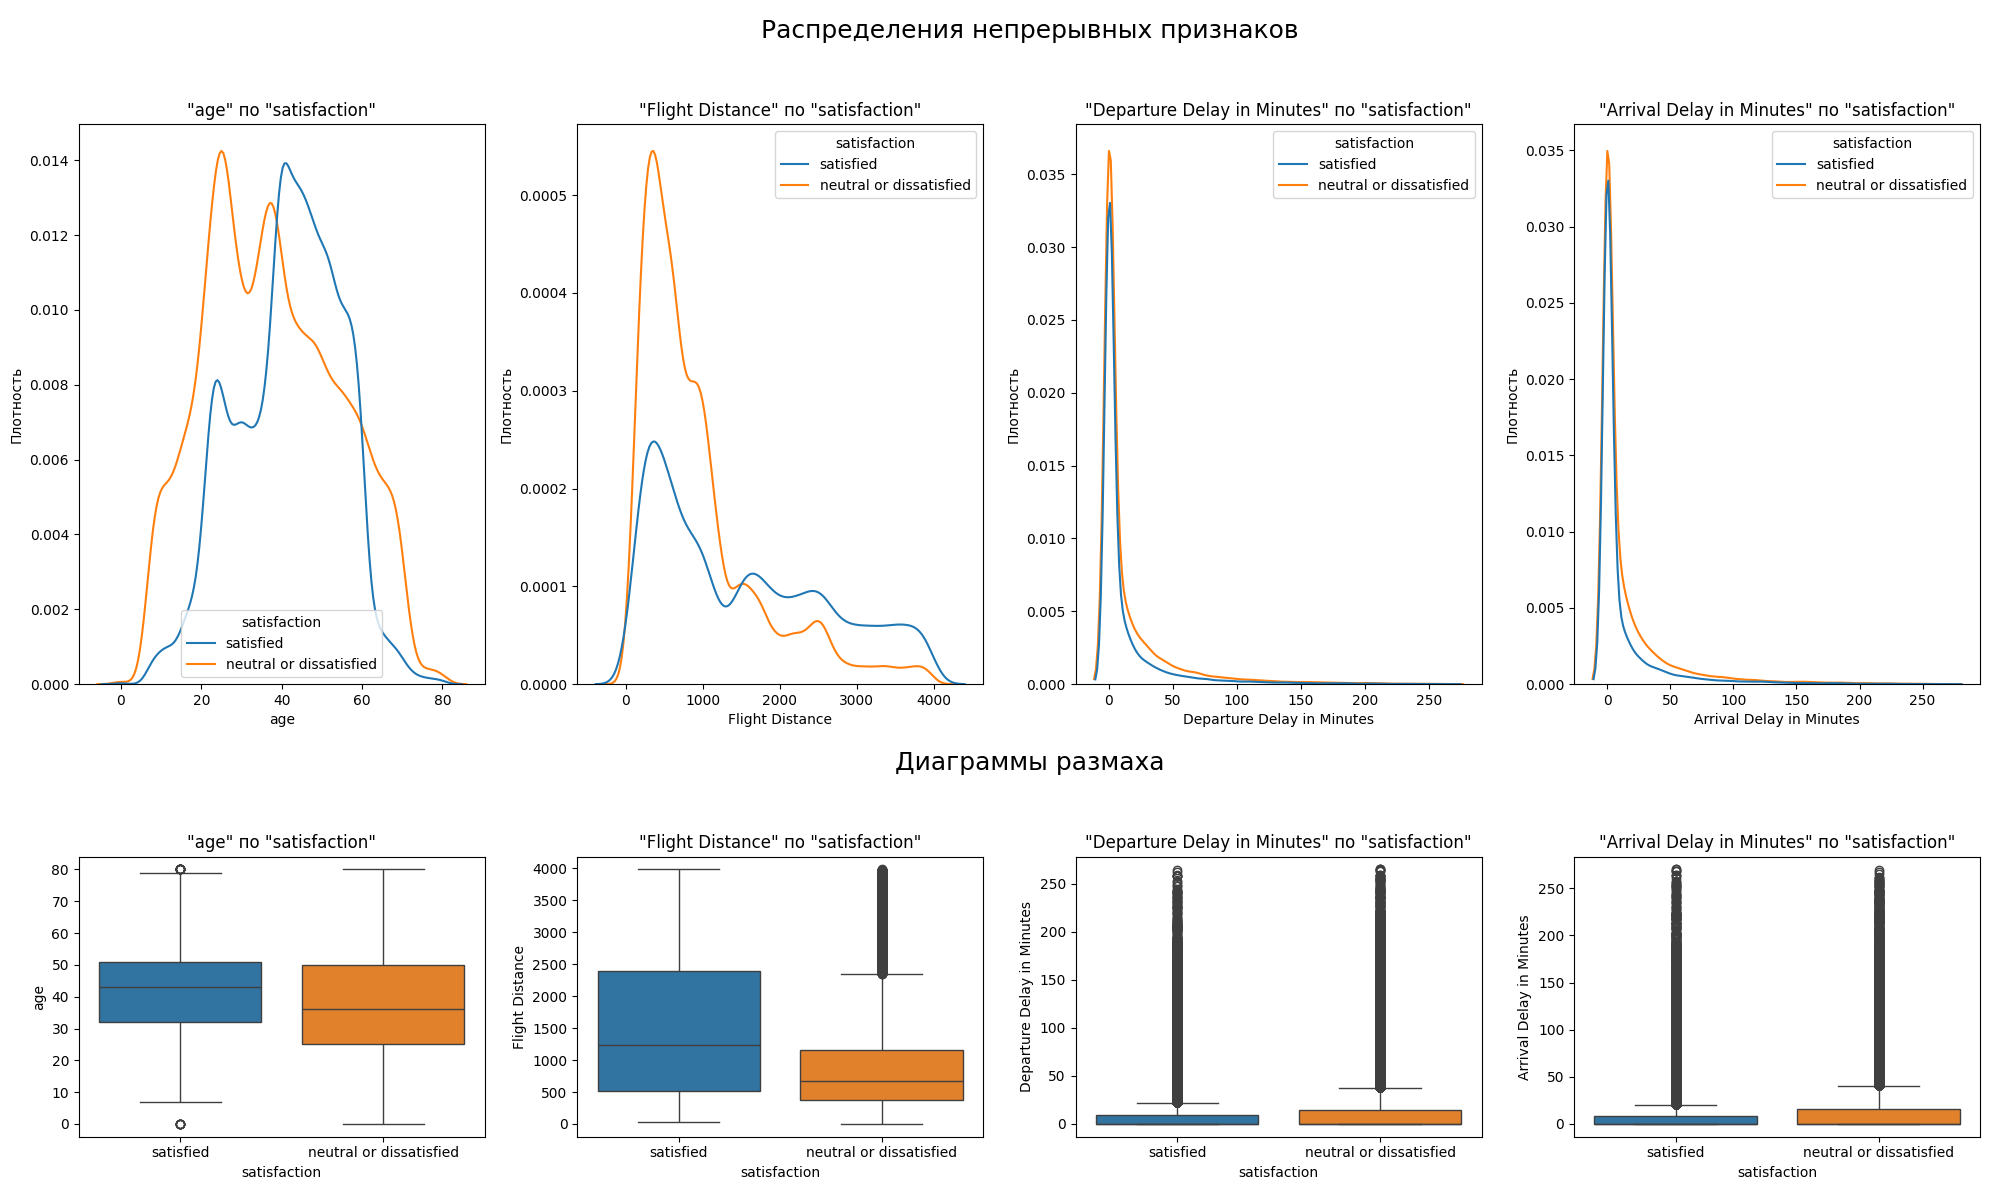

In [40]:
plot_continuous(continuous_cols, X_train, y_train)

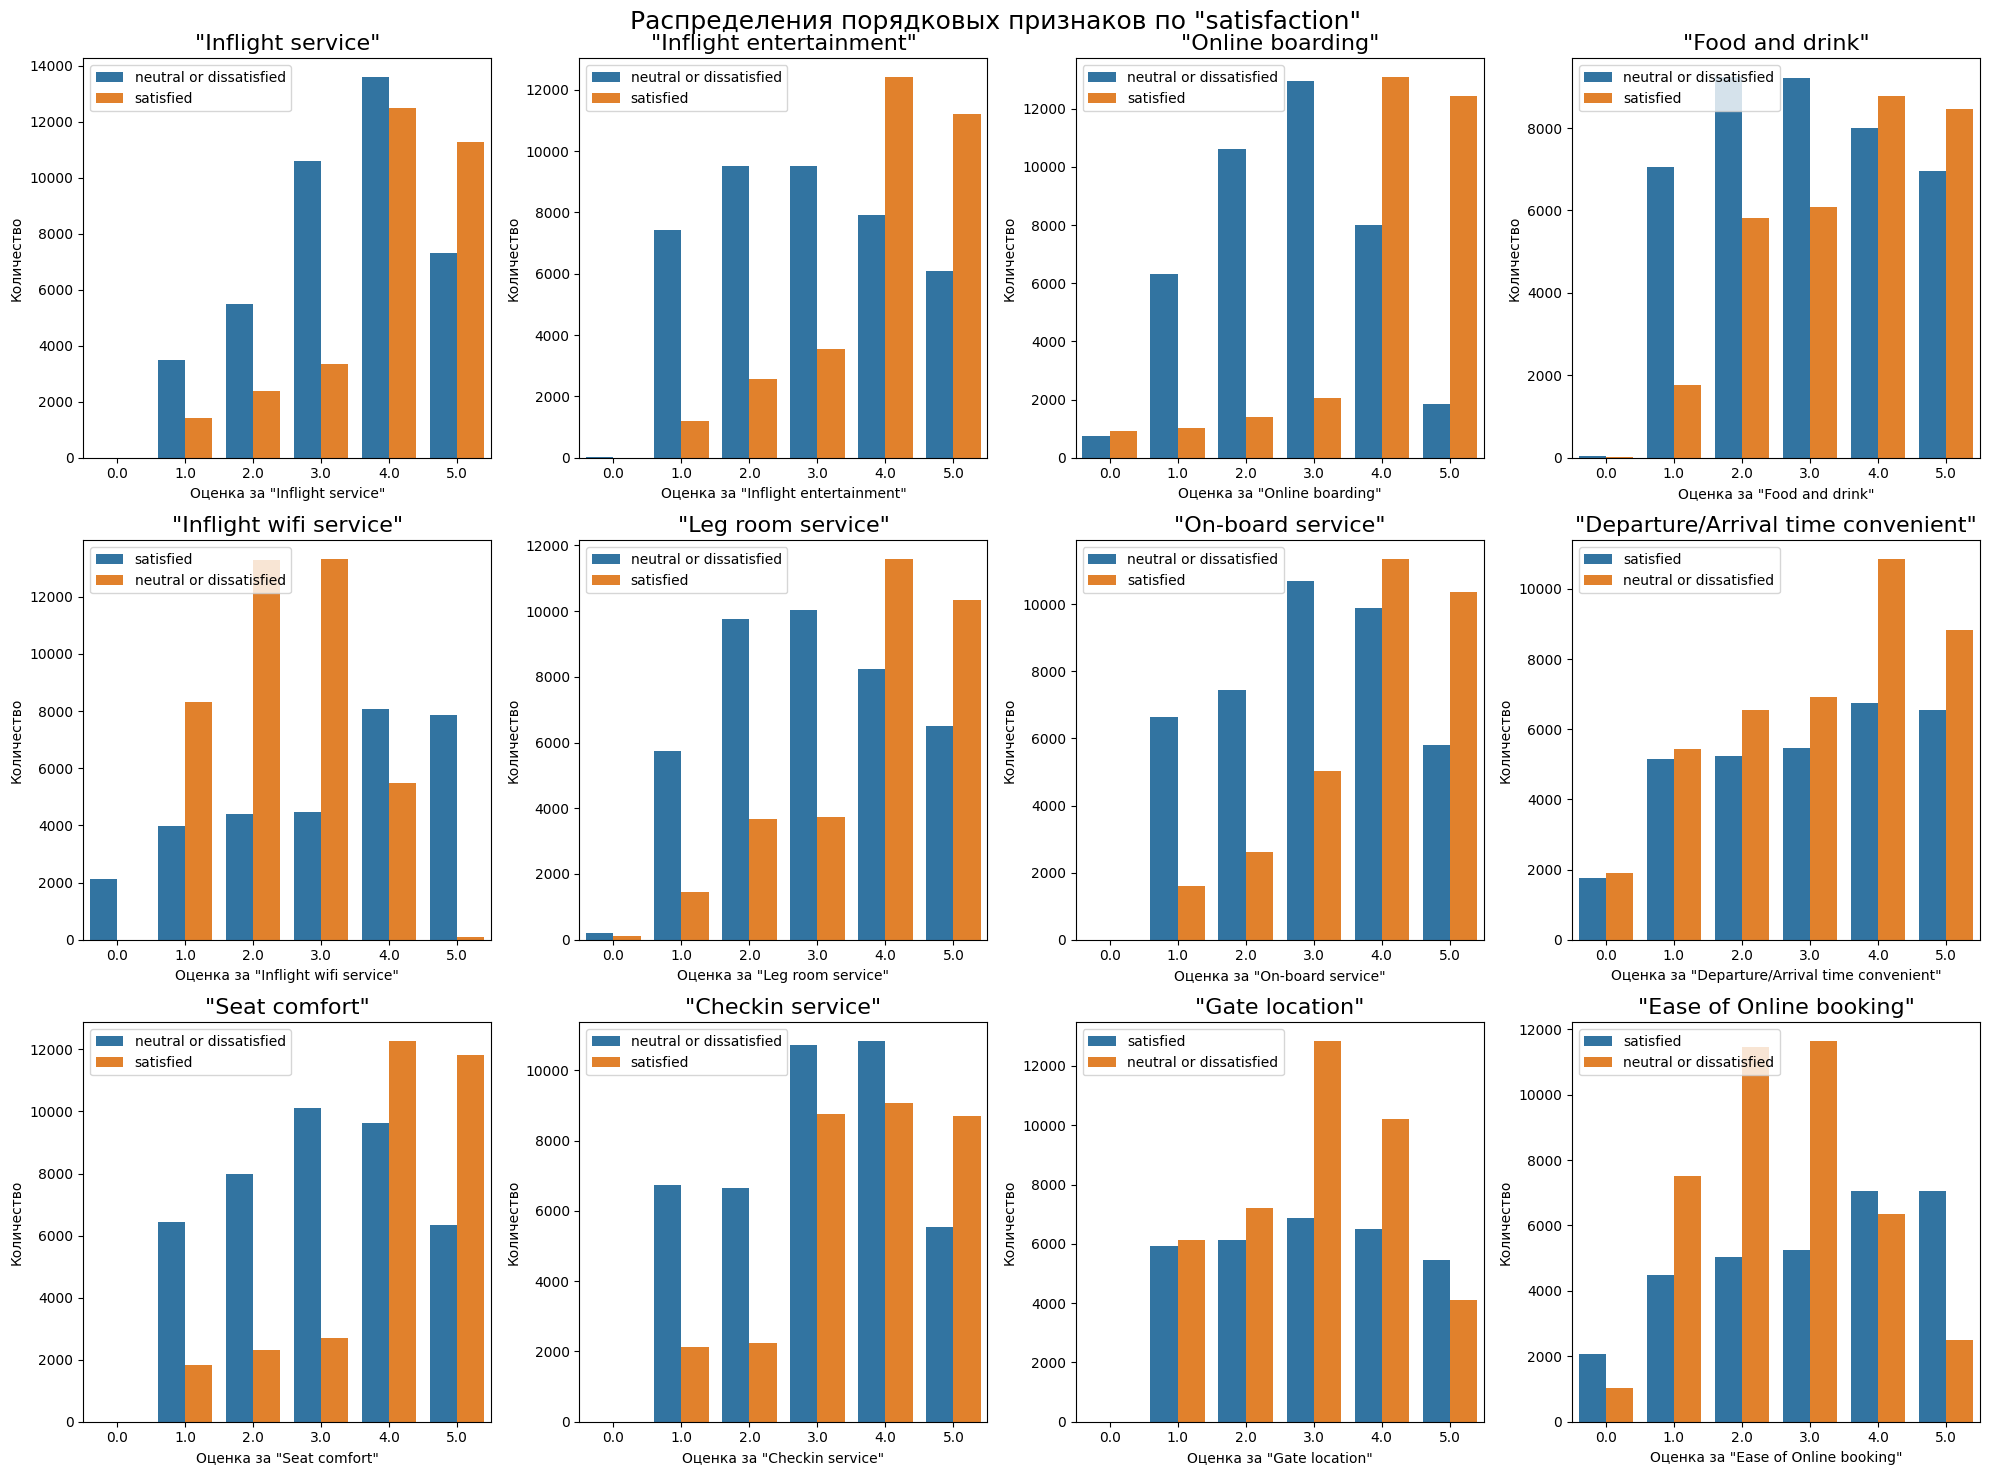

In [41]:
plot_ordinal(ordinal_cols, X_train, y_train)

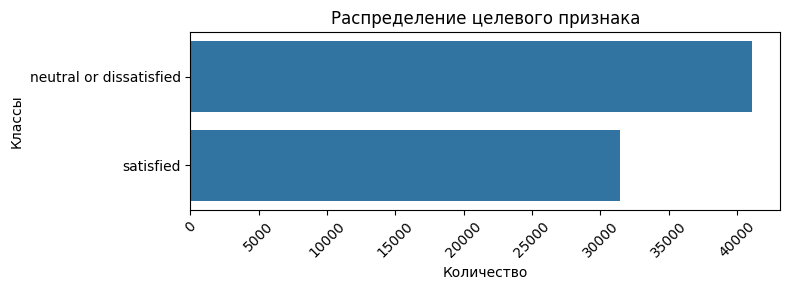

In [42]:
# visualize y_train
plt.figure(figsize=(8, 3))
sns.countplot(data=y_train)
plt.title('Распределение целевого признака')
plt.xlabel('Количество')
plt.ylabel('Классы')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

#### Выводы по построенным графикам

**Целевой признак** `satisfaction`

Классы "satisfied" и "neutral or dissatisfied" не сбалансированы. Больше клиентов недовольны или нейтральны.

**Категориальные признаки**

`Customer Type`: Несбалансированное распределение.  
Большинство клиентов — лояльные. Нелояльные клиенты гораздо реже бывают довольны.

`Type of Travel`: Несбалансированное распределение.  
Бизнес-поездки преобладают над личными. Удовлетворенность выше среди бизнес-путешественников.

`Class`: Несбалансированное распределение.  
Классы "Business" и "Eco Plus" примерно равны по количеству клиентов, но сильно превосходят "Eco". Уровень удовлетворенности в "Business" и "Eco Plus" противоположен - "Business" имеет больше удовлетворенных клиентов.

`Gender`: Сбалансированное распределение.  
Женщины чаще недовольны, чем мужчины.

**Континуальные признаки**

`Age`: _Бимодальное распределение_. По отдельным классам удовлетворенности - похоже на нормальное. Удовлетворенные клиенты в среднем немного старше (смещены вправо). (возможна хорошая информативность признака)

`Flight Distance`: _Правостороннее смещенное распределение_ - большая часть значений сосредоточена возле 0, но есть длинный хвост вправо. При этом, на короткие расстояния (до 1000 км) приходится значительно больше нейтральных или недовольных клиентов, но на большие расстояния немногно больше удовлетворенных. (возможна хорошая информативность признака)

`Departure Delay in Minutes`: Ярко выраженное _правостороннее смещенное распределение_ - . Это говорит о том, что задержки редкие, но долгие. Различия в удовлетворенности незначительны.

`Arrival Delay in Minutes`: аналогично `Departure Delay in Minutes`.


**Признаки оценки сервиса**

В среднем оценки смещены в сторону 3+. Есть видимые различия в оценках по отдельным классам, т.е. признаки могут быть информативными.


Эти выводы помогают понять, какие признаки могут быть важны для модели и где могут быть проблемы с данными, такие как выбросы или несбалансированность классов.

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

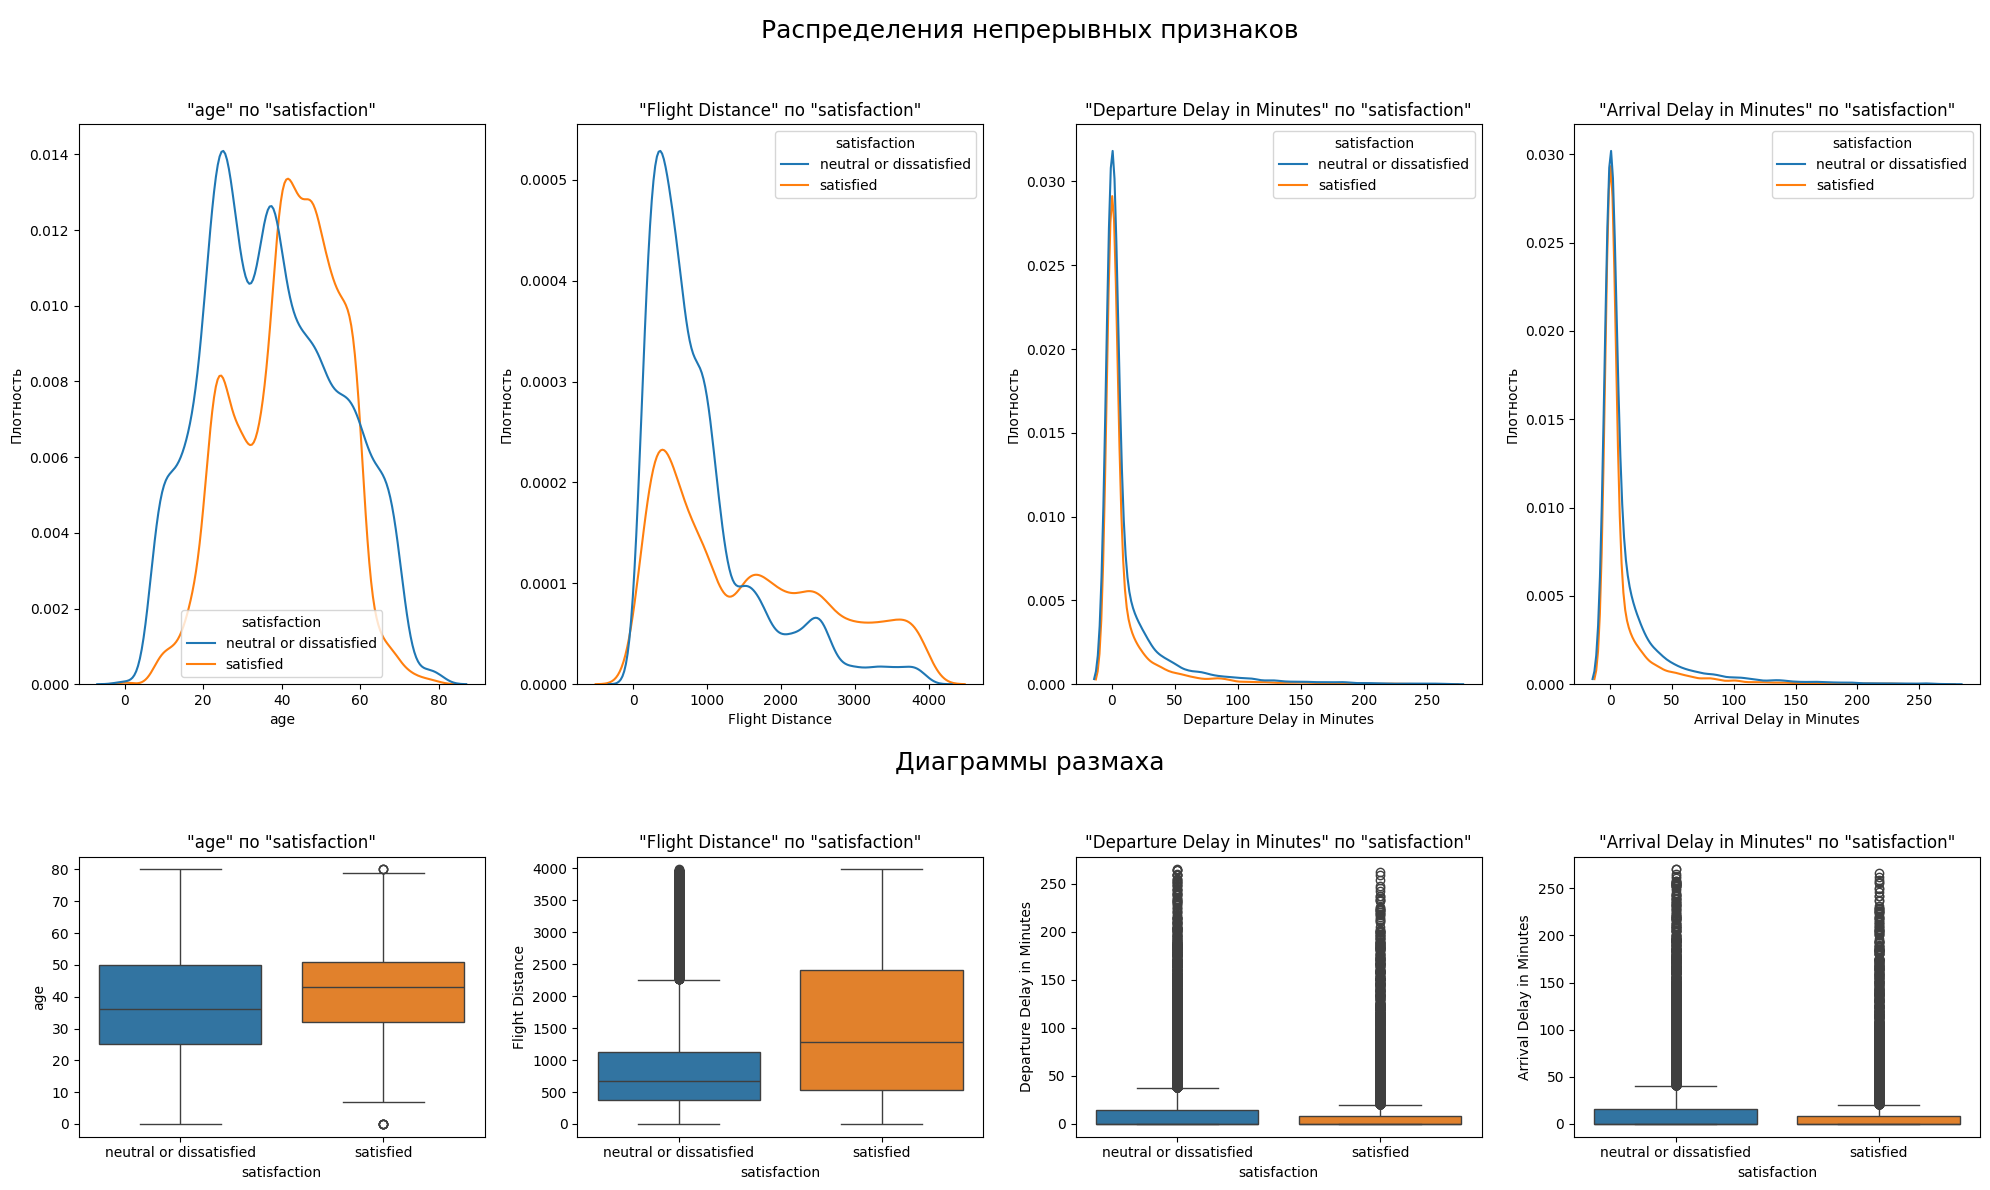

In [43]:
# Ваш код ниже
plot_continuous(continuous_cols, X_val, y_val)

Сравнение распределений признаков в трейне, валидации показывает, что они не сильно отличаются.

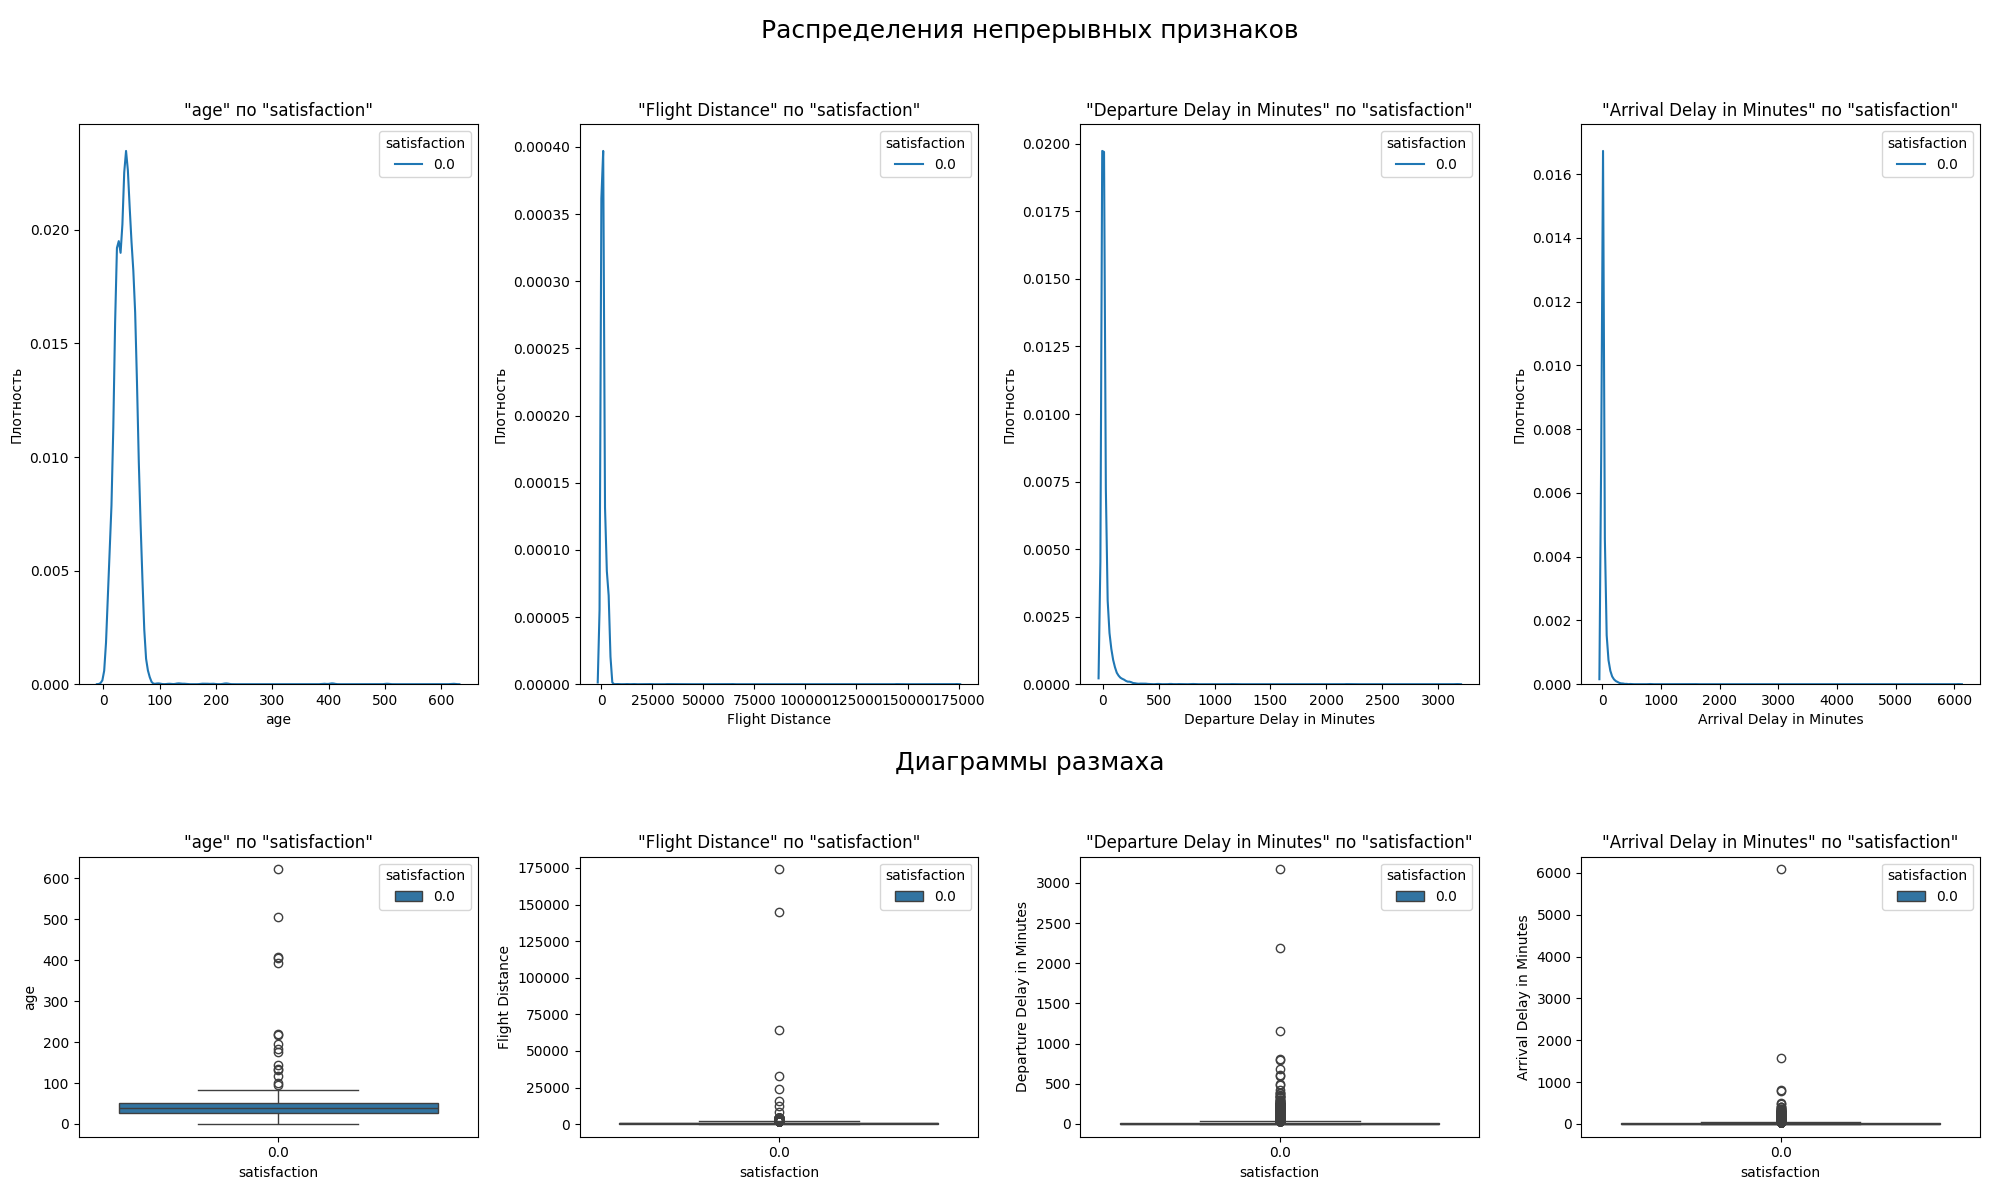

In [44]:
# Для теста сгенерируем вектор из нулей в качестве целевого признака 
# это не совсем точно (должны быть "-"), но для визуализации без разницы подойдет
plot_continuous(continuous_cols, df_test, pd.Series(np.zeros(df_test.shape[0]), name='satisfaction'))

В тесте все еще присуствтуют все выбросы, поэтому распределения несколько отличаются. Хотя много общего


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [45]:
# Ваш код ниже

# чтобы не бороться с нулями, добавим немного
eps = 1e-10

X_train_log = X_train.copy()
X_val_log = X_val.copy() 
X_test_log = df_test.copy()

X_train_log['Departure Delay in Minutes'] = np.log(X_train_log['Departure Delay in Minutes'] + eps)
X_train_log['Arrival Delay in Minutes'] = np.log(X_train_log['Arrival Delay in Minutes'] + eps)

X_val_log['Departure Delay in Minutes'] = np.log(X_val_log['Departure Delay in Minutes'] + eps)
X_val_log['Arrival Delay in Minutes'] = np.log(X_val_log['Arrival Delay in Minutes'] + eps)

X_test_log['Departure Delay in Minutes'] = np.log(X_test_log['Departure Delay in Minutes'] + eps)
X_test_log['Arrival Delay in Minutes'] = np.log(X_test_log['Arrival Delay in Minutes'] + eps)

# X_train = X_train_log
# X_val = X_val_log
# X_test = X_test_log


Построение.

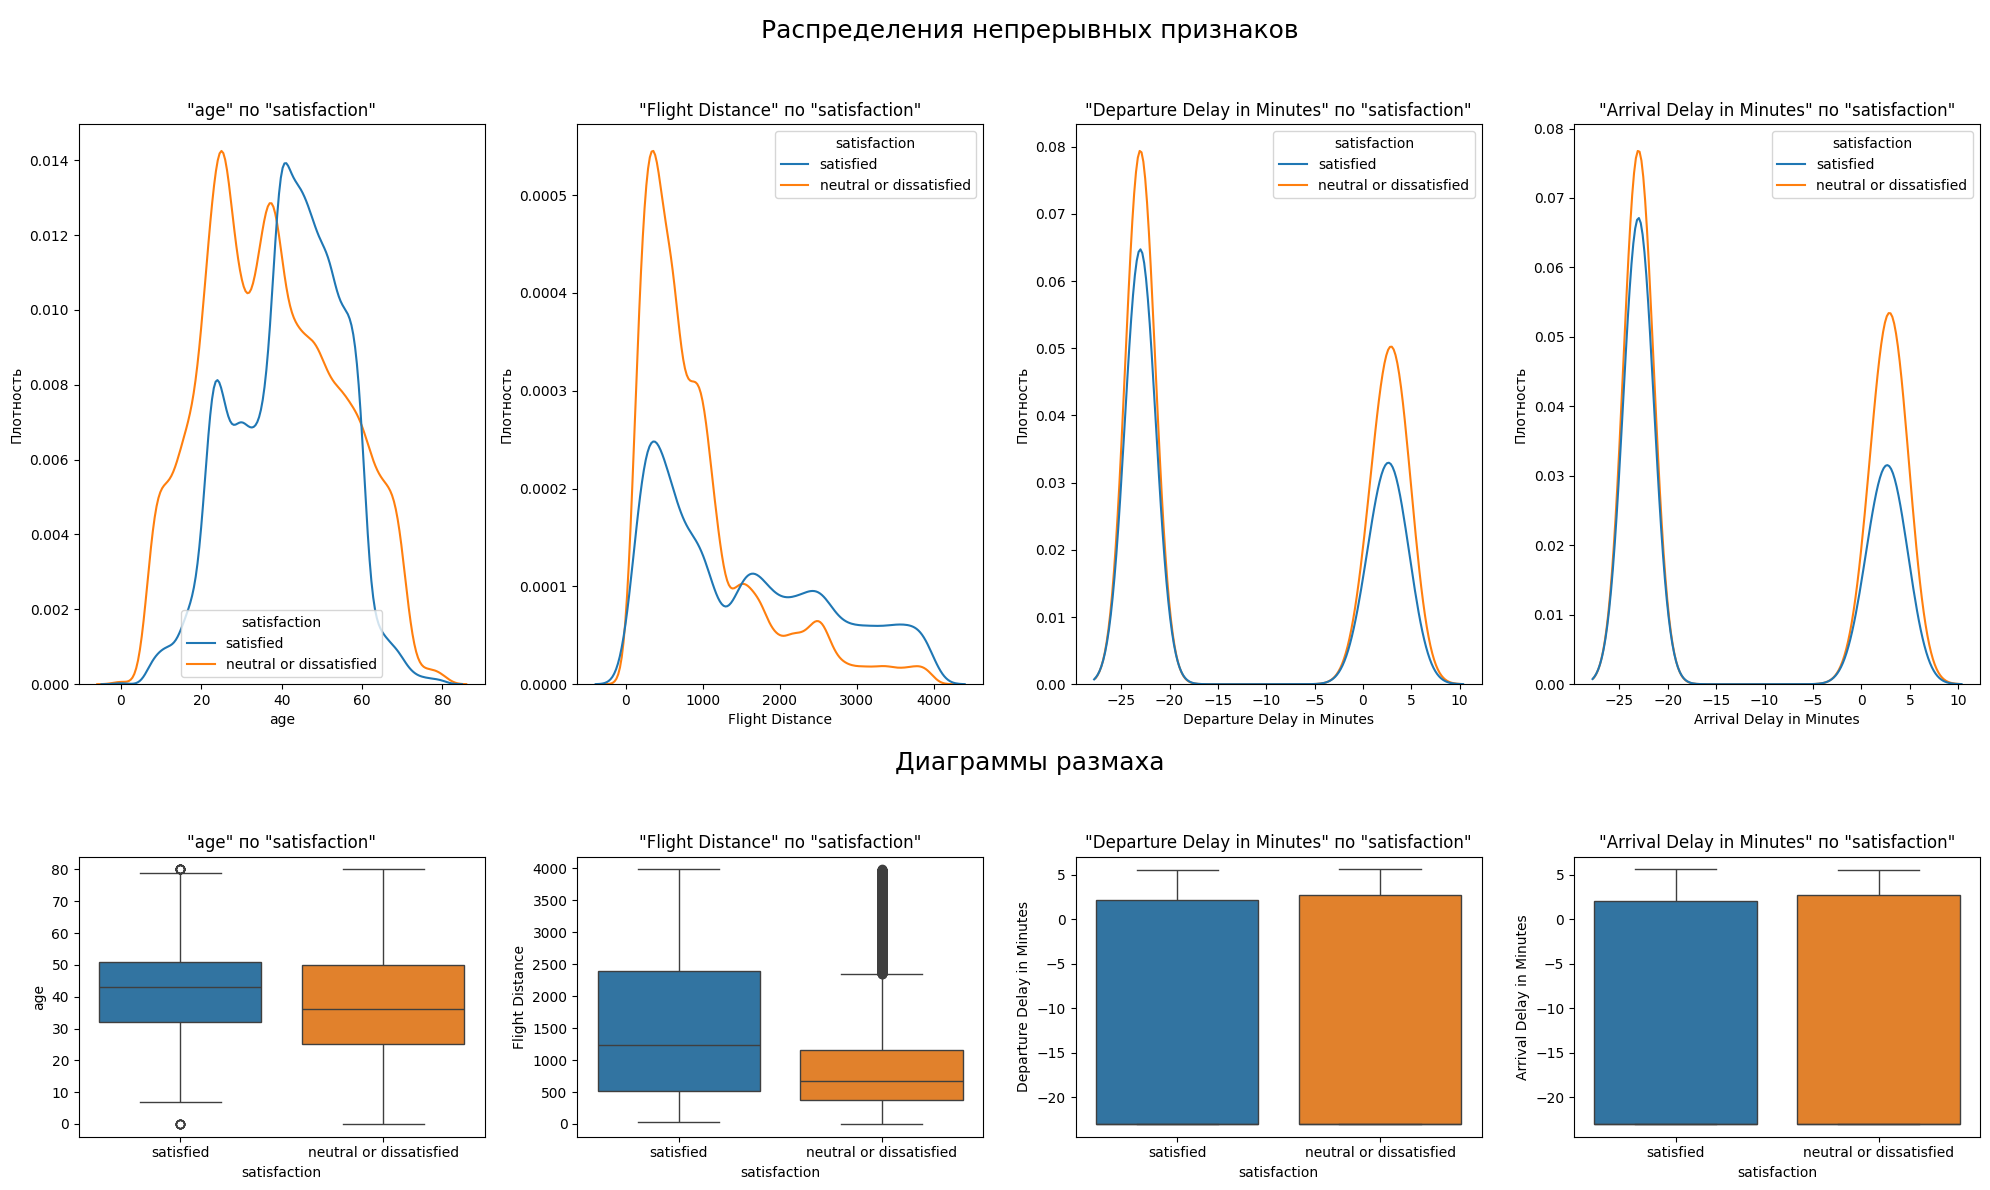

In [46]:
plot_continuous(continuous_cols, X_train_log, y_train)

**Вывод**

После логарифмирования, значения получили бимодальные распределения с резко выраженными пиками, откуда стало очевидно, что либо задержки  очень маленькие, либо редкие, но большие. Распределение "маленьких" и "больших" задержек примерно одинаковое (нормальное). При больших задержках недовольные клиенты более заметны. Это может помочь модели.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

<Figure size 2000x2000 with 0 Axes>

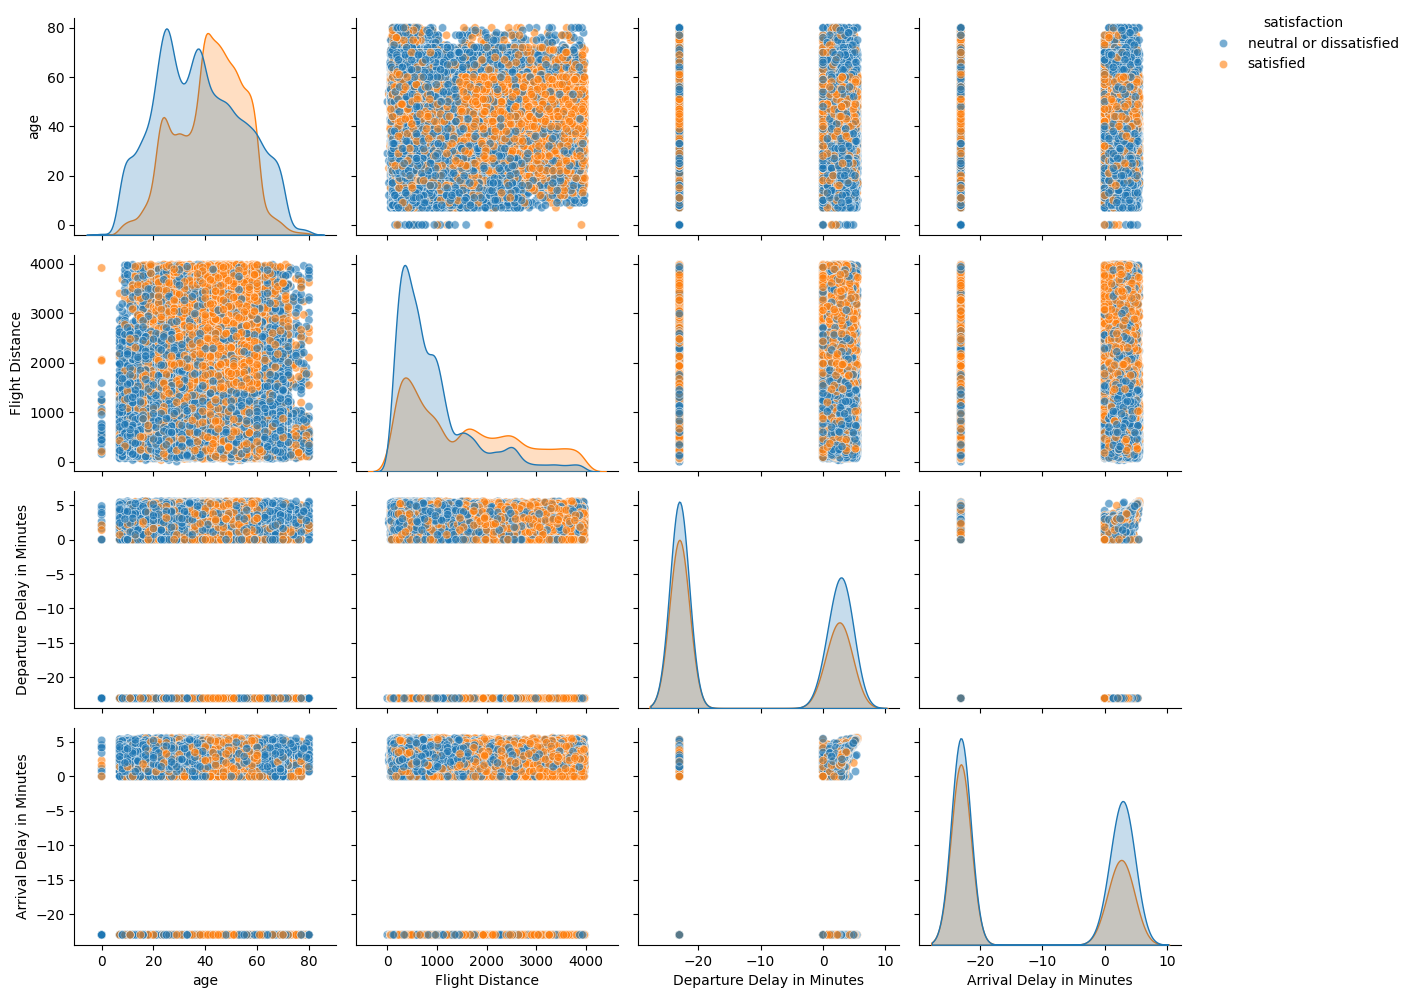

In [49]:
# Ваш код ниже
plt.figure(figsize=(20,20))
plt.suptitle('Попарное распределение континуальных признаков')
plt.subplots_adjust(top=0.9)

ax = sns.pairplot(data=pd.concat([X_train_log[continuous_cols], pd.Series(y_train, name='satisfaction')], axis=1), 
            hue='satisfaction',
            diag_kind='kde',
            plot_kws={'alpha': 0.6})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [ ]:
# Ваш код ниже

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [ ]:
# Ваш код ниже

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp
error_dt, bias_dt, var_dt

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
# Ваш код ниже

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

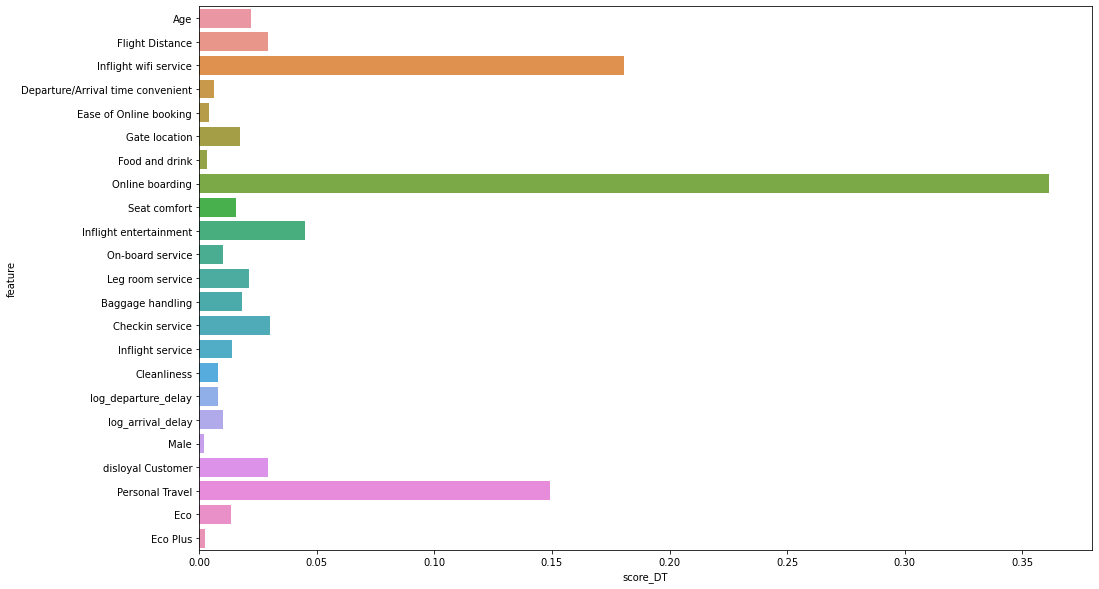

In [ ]:
# Ваш код здесь

`Ваш ответ здесь.`  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
# Ваш код здесь

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

In [ ]:
# Ваш код здесь


### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [ ]:
# Ваш код здесь

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


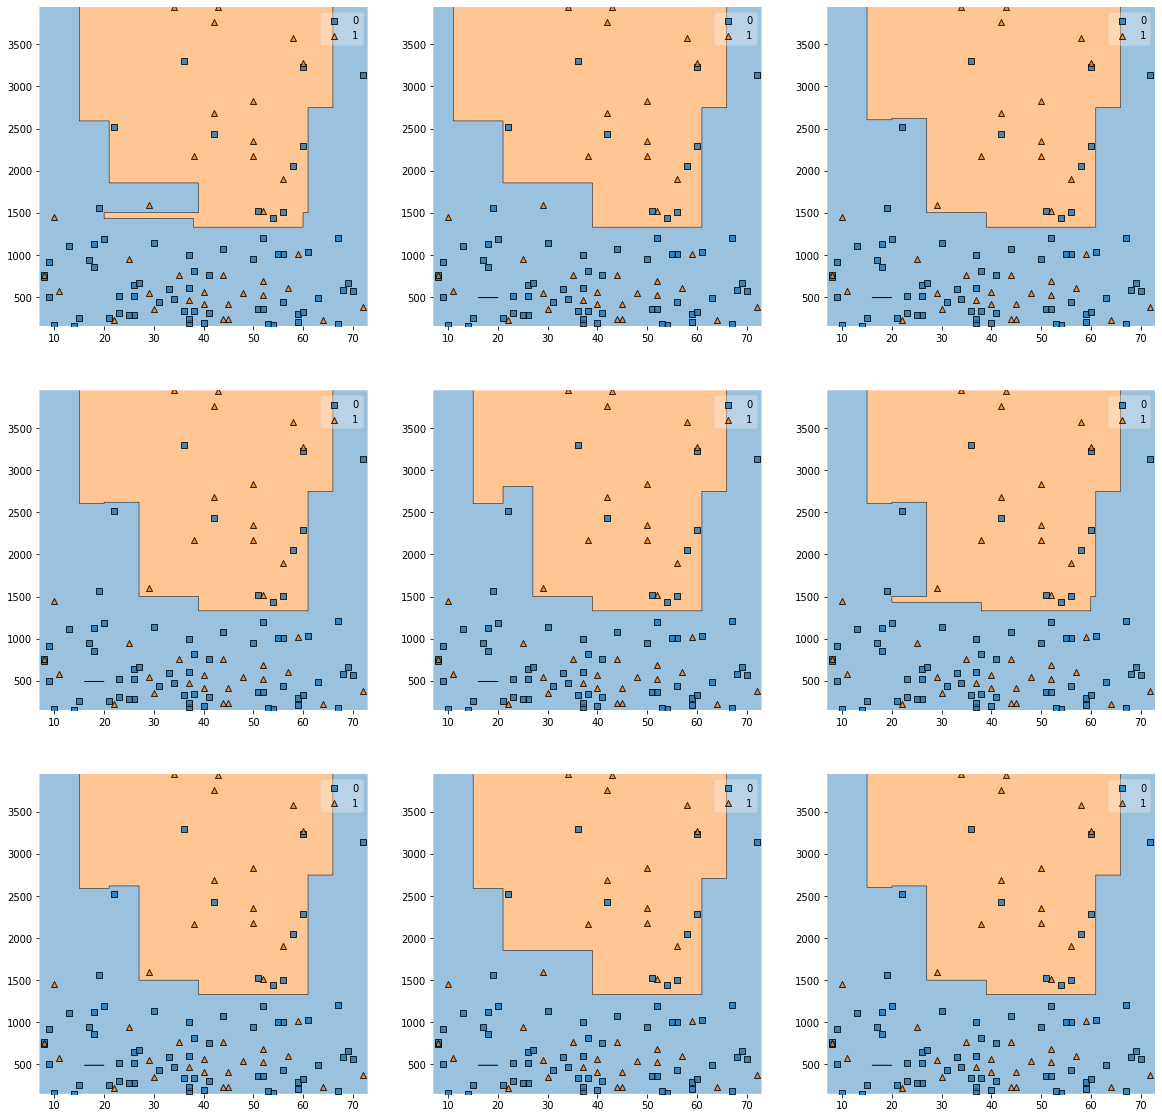

In [ ]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

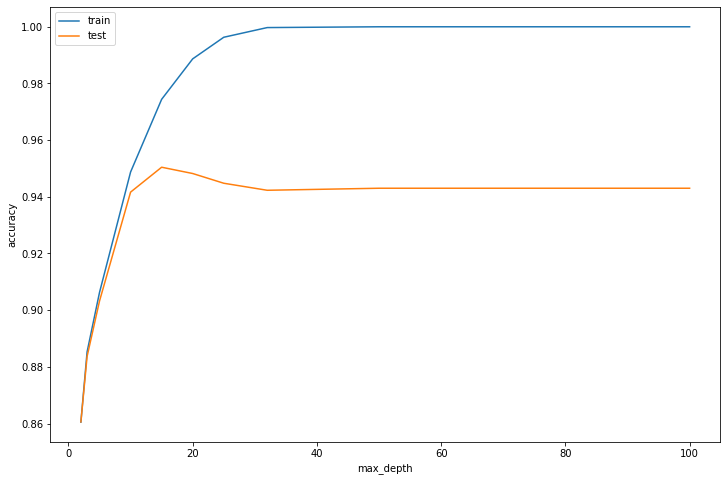

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
# you know what to do



### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
# Ваш код здесь



### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

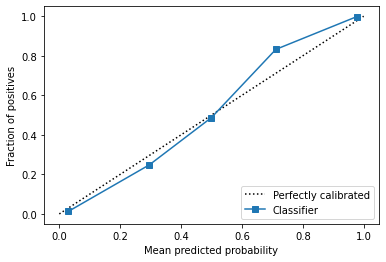

In [ ]:
# Ваш код здесь



Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Ваш ответ здесь
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

CPU times: user 530 ms, sys: 278 ms, total: 808 ms
Wall time: 431 ms


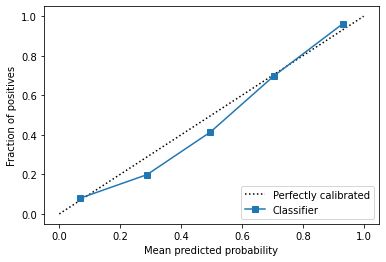

In [ ]:
# Ваш код здесь

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
# Ваш код здесь

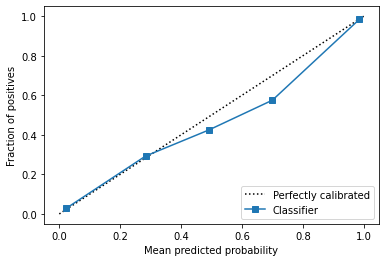

In [ ]:
# Ваш код здесь (Logreg)

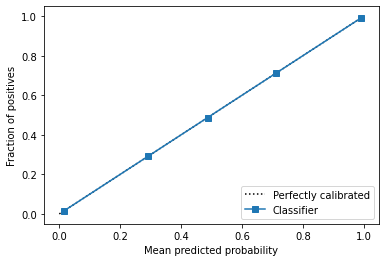

In [ ]:
# Ваш код здесь (isoreg)

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
# Ваш код здесь


```
Ваш ответ здесь
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
# Ваш код здесь


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# Ваш код здесь


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


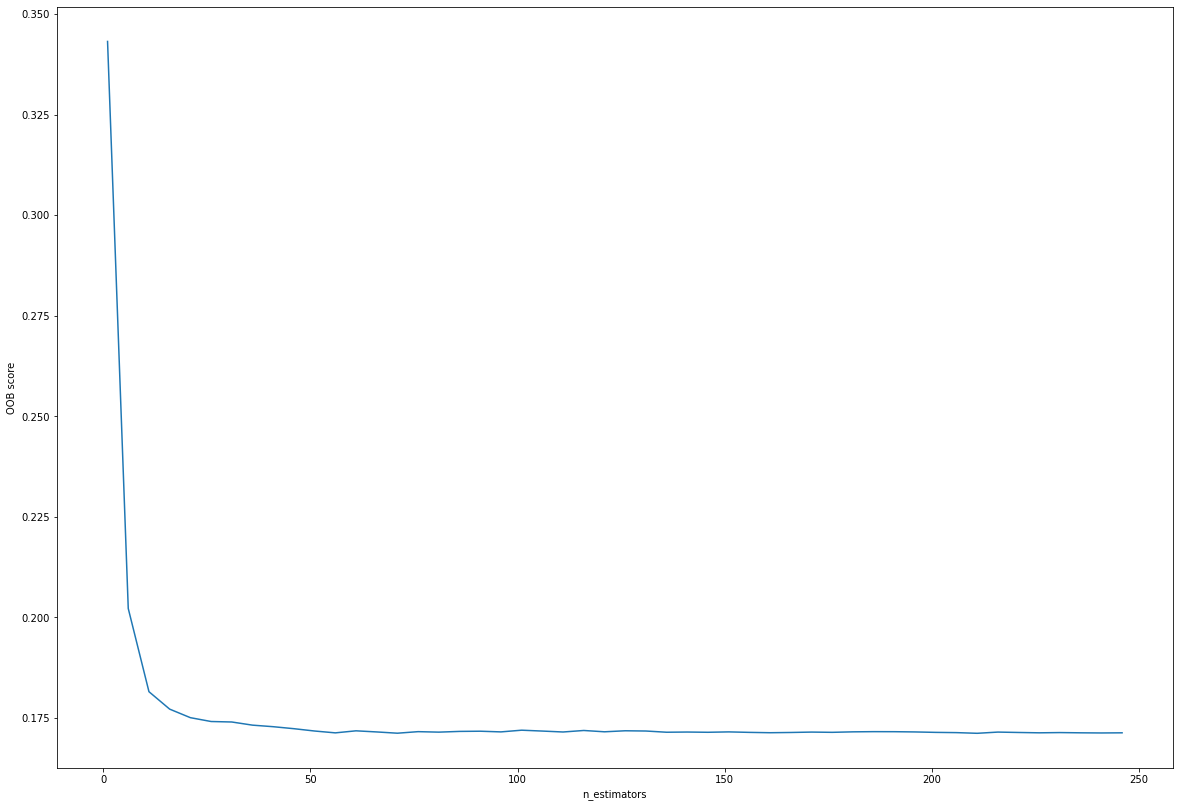

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

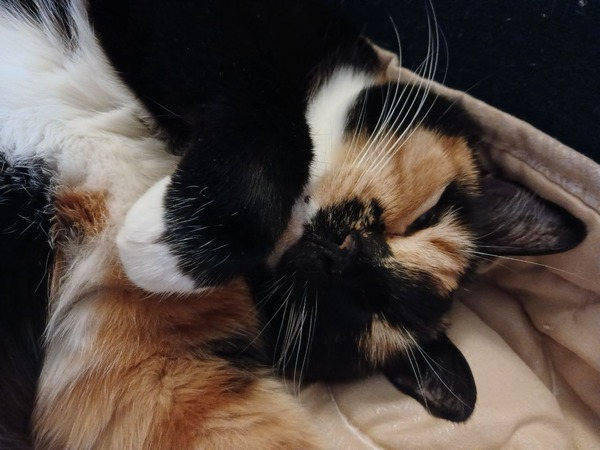

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?